# Lending Club Case Study 

Analyze driving factors behind Load Default and here are the steps to conclude our case study.
- Understanding The Given Dataset
- Clean up the dataset(Replacing missing values, standarizing column's values, removing irrelevant columns, etc. 
- Data Analysis
- Observations

# 1. Understanding The Given Dataset 

In [807]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
from pprint import pprint


In [808]:
loan_data = pd.read_csv("loan.csv", low_memory=False)

In [809]:
(loan_data.isnull().sum()/len(loan_data.index)*100).sort_values(ascending=False)

verification_status_joint    100.0
annual_inc_joint             100.0
mo_sin_old_rev_tl_op         100.0
mo_sin_old_il_acct           100.0
bc_util                      100.0
                             ...  
delinq_amnt                    0.0
policy_code                    0.0
earliest_cr_line               0.0
delinq_2yrs                    0.0
id                             0.0
Length: 111, dtype: float64

## Initial observation of dataset
- There are several variables(columns) contain null values
- Few columns have more than 90% null values
- Identified few customer behaviour columns

In [810]:
loan_data.shape

(39717, 111)

Verify initial loaded dataset

In [811]:
loan_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


### Drop all columns containing only null values

- The above identified columns have 100% null values and these columns are irrelevant in determining the objectives. 
- These columns can be removed from the dataset as they did not provide any meaningful information or contribute to our analysis.

# 2. Data Cleanup

### Remove ID and Member ID columns 
- these columns are unique and will help in the loan defaulter analysis

In [812]:
loan_data = loan_data.drop(['id', 'member_id'], axis=1)

In [813]:
loan_data.shape

(39717, 109)

### Drop all columns containing only null values

- The above identified columns have 100% null values and these columns are irrelevant in determining the objectives. 
- These columns can be removed from the dataset as they did not provide any meaningful information or contribute to our analysis.

In [814]:
all_null_values_columns = [i for i in loan_data.columns if loan_data[i].isna().sum() == len(loan_data)]
pprint(all_null_values_columns)

['mths_since_last_major_derog',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_il_6m',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m',
 'pct_tl_nvr_dlq',
 'percent_bc_gt_75',
 'tot_hi_cred_lim',
 'total_bal

In [815]:
loan_data = loan_data.drop(all_null_values_columns, axis=1)

In [816]:
loan_data.shape

(39717, 55)

### Find columns those have only single value

- We observed that several columns in the dataset contained only a single value across all observations. 
- These constant columns were deemed irrelevant for our analysis as they did not contribute any meaningful variation or    insights. Therefore, we made the decision to remove these columns 

In [817]:
def find_columns_with_same_value(loan_data, threshold=0.95):
    columns_with_same_value = []
    num_rows = len(loan_data)
    
    for column in loan_data.columns:
        value_counts = loan_data[column].value_counts()
        max_count = value_counts.max()
        percentage = max_count / num_rows
        
        if percentage > threshold:
            columns_with_same_value.append(column)
    
    return columns_with_same_value

In [818]:
cols_with_single_value = find_columns_with_same_value(loan_data, threshold=0.99)
pprint(cols_with_single_value)

['pymnt_plan',
 'initial_list_status',
 'collections_12_mths_ex_med',
 'policy_code',
 'application_type',
 'acc_now_delinq',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'tax_liens']


### Drop these columns
- These can't contribute much in the our analysis. Therefor we're removing those from dataframe

In [819]:
loan_data = loan_data.drop(cols_with_single_value, axis=1)

In [820]:
loan_data.shape

(39717, 46)

### Drop all the customer behaviour columns 
- During our analysis of the loan approved data, we identified a set of columns that captured customer behavior variables. These variables, such as acc_now_delinquent and chargeoff within 12 months, provide information about the applicant's past credit behavior. However, since these variables are not available at the time of loan application and are not relevant to our defaulter analysis, we made the decision to drop all the customer behavior columns from the dataset.

The customer behavior variables are not available at the time of loan application, and thus they cannot be used as predictors for credit approval.
 variables such as acc_now_delinquent, chargeoff within 12 months etc. (which are related to the applicant's past loans) are available from the credit bureau.


In [821]:
loan_data = loan_data.drop(['delinq_2yrs','earliest_cr_line','inq_last_6mths','open_acc','pub_rec','revol_bal','total_acc','out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_d','last_pymnt_amnt','last_credit_pull_d']
, axis=1)

In [822]:
loan_data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,purpose,title,zip_code,addr_state,dti,mths_since_last_delinq,mths_since_last_record,revol_util,next_pymnt_d,pub_rec_bankruptcies
0,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,...,credit_card,Computer,860xx,AZ,27.65,NaN,NaN,83.70%,NaN,0.0
1,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,...,car,bike,309xx,GA,1.00,NaN,NaN,9.40%,NaN,0.0
2,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,...,small_business,real estate business,606xx,IL,8.72,NaN,NaN,98.50%,NaN,0.0
3,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,...,other,personel,917xx,CA,20.00,35.0,NaN,21%,NaN,0.0
4,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,...,other,Personal,972xx,OR,17.94,38.0,NaN,53.90%,Jun-16,0.0


In [823]:
loan_data.shape

(39717, 27)

In [824]:
loan_data.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'mths_since_last_delinq', 'mths_since_last_record',
       'revol_util', 'next_pymnt_d', 'pub_rec_bankruptcies'],
      dtype='object')

### Now we have 26 remaining columns and further analysing the existing columns. Here are a few more to drop

We thoroughly examined the user-submitted information for loan approval and identified several columns that do not significantly contribute to the defaulter analysis. These columns, including "url", "desc", "zip_code" and "mths_since_last_delinq", "mths_since_last_delinq", "next_pymnt_d"are deemed irrelevant for the default analysis as they do not provide meaningful insights into the driving factors of loan default

- Analysize the user submitted information for loan approval and consider all strong driving factors of loan defaulting before approving loan.
- "desc" column has description about the loan that won't any driving factors for loan default.
- "url" and "zip_code" columns are irrelevant for default analysis
- "mths_since_last_delinq", "mths_since_last_record", "next_pymnt_d" columns are post approval variables.

In [825]:
loan_data = loan_data.drop(['url', 'desc', 'zip_code', 'mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d'], axis=1)

In [826]:
loan_data.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'purpose', 'title', 'addr_state', 'dti', 'revol_util',
       'pub_rec_bankruptcies'],
      dtype='object')

In [827]:
loan_data.shape

(39717, 21)

### Time to Data Cleanup and Modification
Identify rows to drop and columns to modify values

#### 1. The goal is to analysis different variables to find the strong driving factors to be default for that fully paid or charged off records are needed.
- Current loans won't help us to analysis default
- Removing the current loan records

In [828]:
loan_data = loan_data[loan_data.loan_status != "Current"]
loan_data.loan_status.unique()

array(['Fully Paid', 'Charged Off'], dtype=object)

In [829]:
loan_data.shape

(38577, 21)

#### 2. Identify columns those have missing values in percentage

In [830]:
(loan_data.isna().sum()/len(loan_data.index)) *100

loan_amnt               0.000000
funded_amnt             0.000000
funded_amnt_inv         0.000000
term                    0.000000
int_rate                0.000000
installment             0.000000
grade                   0.000000
sub_grade               0.000000
emp_title               6.185033
emp_length              2.677761
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
issue_d                 0.000000
loan_status             0.000000
purpose                 0.000000
title                   0.028514
addr_state              0.000000
dti                     0.000000
revol_util              0.129611
pub_rec_bankruptcies    1.806776
dtype: float64

#### 3. Handle missing data of emp_length column 

In [831]:
loan_data['emp_length'].value_counts()

10+ years    8488
< 1 year     4508
2 years      4291
3 years      4012
4 years      3342
5 years      3194
1 year       3169
6 years      2168
7 years      1711
8 years      1435
9 years      1226
Name: emp_length, dtype: int64

In [832]:
mode_value = loan_data.emp_length.mode()[0]

In [833]:
loan_data.emp_length.fillna(mode_value, inplace = True)
loan_data.emp_length.isna().sum()

0

In [834]:
loan_data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,annual_inc,verification_status,issue_d,loan_status,purpose,title,addr_state,dti,revol_util,pub_rec_bankruptcies
0,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,...,24000.0,Verified,Dec-11,Fully Paid,credit_card,Computer,AZ,27.65,83.70%,0.0
1,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,...,30000.0,Source Verified,Dec-11,Charged Off,car,bike,GA,1.00,9.40%,0.0
2,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,...,12252.0,Not Verified,Dec-11,Fully Paid,small_business,real estate business,IL,8.72,98.50%,0.0
3,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,...,49200.0,Source Verified,Dec-11,Fully Paid,other,personel,CA,20.00,21%,0.0
5,5000,5000,5000.0,36 months,7.90%,156.46,A,A4,Veolia Transportaton,3 years,...,36000.0,Source Verified,Dec-11,Fully Paid,wedding,My wedding loan I promise to pay back,AZ,11.20,28.30%,0.0


### Transform few column's values in a standard form
- int_rate column needs to be transformed
- emp_length column needs to be transformed
- home_ownership replacing 'NONE' with 'OTHERS'

In [835]:
loan_data.int_rate = loan_data.int_rate.apply(lambda x : float(x.split('%')[0]))

In [836]:
def transform_emp_length(emp_length):
    match_value = int(re.findall(r'\d+', emp_length)[0])
    if match_value == 1:
        return 0
    else:
        return match_value
        

In [837]:
loan_data.emp_length = loan_data.emp_length.apply(transform_emp_length)

In [838]:

loan_data['home_ownership'].replace(to_replace = ['NONE'],value='OTHER',inplace = True)

In [839]:
loan_data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,annual_inc,verification_status,issue_d,loan_status,purpose,title,addr_state,dti,revol_util,pub_rec_bankruptcies
0,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10,...,24000.0,Verified,Dec-11,Fully Paid,credit_card,Computer,AZ,27.65,83.70%,0.0
1,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,0,...,30000.0,Source Verified,Dec-11,Charged Off,car,bike,GA,1.00,9.40%,0.0
2,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10,...,12252.0,Not Verified,Dec-11,Fully Paid,small_business,real estate business,IL,8.72,98.50%,0.0
3,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10,...,49200.0,Source Verified,Dec-11,Fully Paid,other,personel,CA,20.00,21%,0.0
5,5000,5000,5000.0,36 months,7.90,156.46,A,A4,Veolia Transportaton,3,...,36000.0,Source Verified,Dec-11,Fully Paid,wedding,My wedding loan I promise to pay back,AZ,11.20,28.30%,0.0


# 3. Data Analysis
The goal of this case study to understand which variables are significant contribution to make loan default.

In [840]:
loan_data.describe()


,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,emp_length,annual_inc,dti,pub_rec_bankruptcies
count,38577.000000,38577.000000,38577.000000,38577.000000,38577.000000,38577.000000,3.857700e+04,38577.000000,37880.000000
mean,11047.025430,10784.058506,10222.481123,11.932219,322.466318,4.994297,6.877797e+04,13.272727,0.043479
std,7348.441646,7090.306027,7022.720644,3.691327,208.639215,3.704885,6.421868e+04,6.673044,0.204583
min,500.000000,500.000000,0.000000,5.420000,15.690000,0.000000,4.000000e+03,0.000000,0.000000
25%,5300.000000,5200.000000,5000.000000,8.940000,165.740000,2.000000,4.000000e+04,8.130000,0.000000
50%,9600.000000,9550.000000,8733.440000,11.710000,277.860000,4.000000,5.886800e+04,13.370000,0.000000
75%,15000.000000,15000.000000,14000.000000,14.380000,425.550000,9.000000,8.200000e+04,18.560000,0.000000
max,35000.000000,35000.000000,35000.000000,24.400000,1305.190000,10.000000,6.000000e+06,29.990000,2.000000


In [841]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 0 to 39716
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             38577 non-null  int64  
 1   funded_amnt           38577 non-null  int64  
 2   funded_amnt_inv       38577 non-null  float64
 3   term                  38577 non-null  object 
 4   int_rate              38577 non-null  float64
 5   installment           38577 non-null  float64
 6   grade                 38577 non-null  object 
 7   sub_grade             38577 non-null  object 
 8   emp_title             36191 non-null  object 
 9   emp_length            38577 non-null  int64  
 10  home_ownership        38577 non-null  object 
 11  annual_inc            38577 non-null  float64
 12  verification_status   38577 non-null  object 
 13  issue_d               38577 non-null  object 
 14  loan_status           38577 non-null  object 
 15  purpose            

## 3.1 Handle Outlier and remove them if required
- These are a few columns which we have to take care - loan_amnt, annual_inc, dti, founded_amnt_inv, funded_amnt

<Axes: ylabel='loan_amnt'>

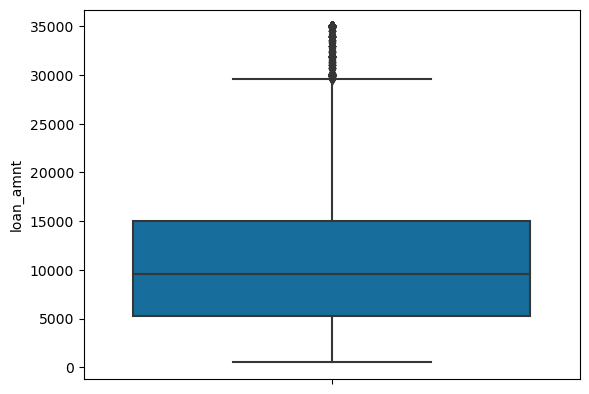

In [842]:
sns.boxplot(data=loan_data, y='loan_amnt')


In [843]:
def find_outlier_values(column_data):
    outlier_values = []
    Q1 = column_data.quantile(0.25)
    Q3 = column_data.quantile(0.75)
    IQR = Q3 - Q1
    threshold_low = Q1 - 1.5 * IQR
    threshold_high = Q3 + 1.5 * IQR
    outlier_values = (column_data < threshold_low) | (column_data > threshold_high)
    return outlier_values.value_counts()

In [844]:
def quantile_values(column_name):
    return loan_data[column_name].quantile([0.5,0.75,0.90,0.95,0.97,0.975, 0.98,0.985, 0.99, 1.0])

In [845]:
find_outlier_values(loan_data.loan_amnt)

False    37489
True      1088
Name: loan_amnt, dtype: int64

In [846]:
quantile_values('loan_amnt')

0.500     9600.0
0.750    15000.0
0.900    21600.0
0.950    25000.0
0.970    28000.0
0.975    30000.0
0.980    30000.0
0.985    35000.0
0.990    35000.0
1.000    35000.0
Name: loan_amnt, dtype: float64

<Axes: xlabel='funded_amnt_inv'>

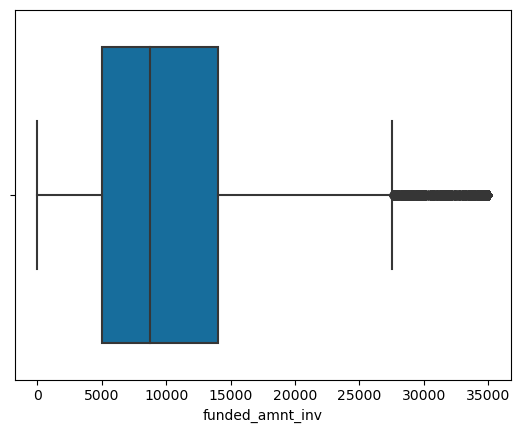

In [847]:
sns.boxplot(data=loan_data, x="funded_amnt_inv")

In [848]:
find_outlier_values(loan_data.funded_amnt_inv)

False    37543
True      1034
Name: funded_amnt_inv, dtype: int64

In [849]:
quantile_values('funded_amnt_inv')

0.500     8733.440000
0.750    14000.000000
0.900    19975.000000
0.950    24500.066590
0.970    25750.000000
0.975    27975.000000
0.980    29879.258133
0.985    30000.000000
0.990    34715.012285
1.000    35000.000000
Name: funded_amnt_inv, dtype: float64

<Axes: xlabel='annual_inc'>

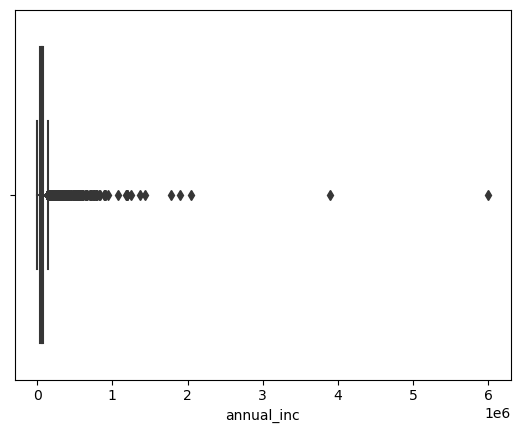

In [850]:
sns.boxplot(data=loan_data, x="annual_inc")

In [851]:
find_outlier_values(loan_data.annual_inc)

False    36815
True      1762
Name: annual_inc, dtype: int64

In [852]:
quantile_values('annual_inc')

0.500      58868.0
0.750      82000.0
0.900     115000.0
0.950     140004.0
0.970     165000.0
0.975     175000.0
0.980     187000.0
0.985     200000.0
0.990     234144.0
1.000    6000000.0
Name: annual_inc, dtype: float64

#### Based on the plotting it's clearly showing outliers
- We need to remove them and we can simply analyse through quantile that values are disconnected after 95 percentile.
- We can consider 0.95 threshold

In [853]:
per_95_annual_inc = loan_data.annual_inc.quantile(0.95)
loan_data = loan_data[loan_data.annual_inc <= per_95_annual_inc]

<Axes: xlabel='annual_inc'>

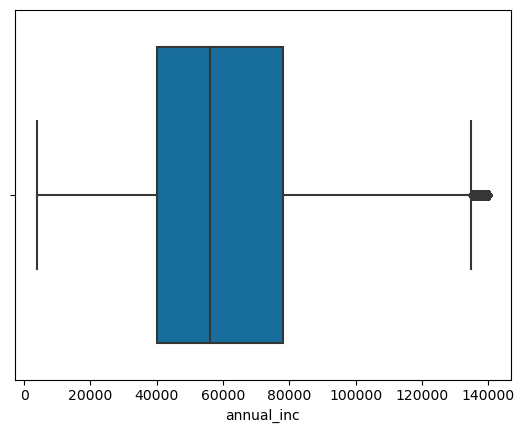

In [854]:
sns.boxplot(data=loan_data, x="annual_inc")

<Axes: xlabel='dti'>

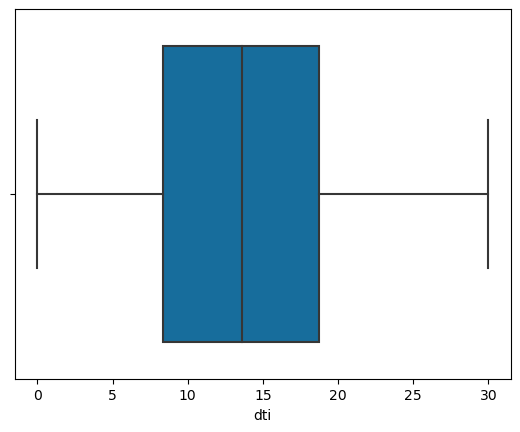

In [855]:
sns.boxplot(data=loan_data, x="dti")

- After observing all the box plots, there was only annual income required to remove outliers rest all the distributions are continous and no need to remove any outliers for now.

## 3.2 Univariate Analysis for Categorical variables

- loan_status gives us visualize view of fully paid and charged off ratio. 

<Axes: xlabel='loan_status', ylabel='count'>

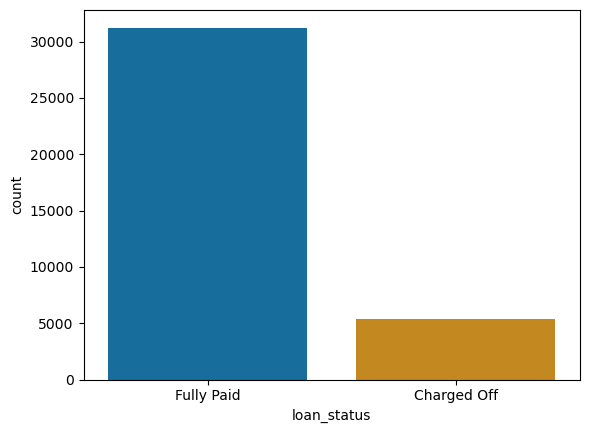

In [856]:
sns.countplot(x = 'loan_status', data = loan_data)

- Visualize grade and sub_grade view against loan_status charged_off

loan_status variable has now two values "Fully Paid" and "Charged Off"

We can convert these values to 0 and 1
0 - False
1 - True

In [857]:
loan_data['loan_status'] = loan_data['loan_status'].apply(lambda x: 0 if  x == 'Fully Paid' else 1)

##### Converting loan_status to integer type

In [858]:
loan_data['loan_status'] = loan_data['loan_status'].apply(lambda x: pd.to_numeric(x))

# summarising the values
loan_data['loan_status'].value_counts()

0    31236
1     5418
Name: loan_status, dtype: int64

##### Drop all null value from revol_util variable

In [859]:
loan_data.dropna(axis = 0, subset = ['revol_util'] , inplace = True)

In [860]:
loan_data.revol_util.isna().sum()

0

##### Transform percentage to float for revol_util column

In [861]:
def transform_column_values(col_val):
    return pd.to_numeric(col_val.split('%')[0])

##### Converting revol_util to integer type

In [862]:
loan_data.revol_util = loan_data.revol_util.apply(transform_column_values)

##### default rate

In [863]:
round(np.mean(loan_data['loan_status']), 2)

0.15

The overall default rate is about 15%.

Let's first visualise the average default rates across categorical variables.

In [864]:
category_variables = [
    'verification_status','term', 'grade', 'sub_grade', 'home_ownership','purpose'
]
continous_variables = [
    'loan_amnt', 'funded_amnt_inv','int_rate', 'installment', 'emp_length','annual_inc', 'revol_util']
                       

Let's group the category and contious variables

##### plotting default rates across grade against the loan_status

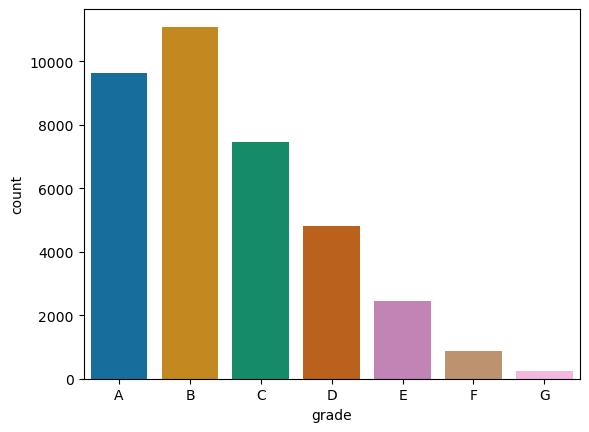

In [865]:
sns.countplot(x = 'grade', data = loan_data, order = ['A', 'B', 'C', 'D', 'E', 'F', 'G'])
plt.show()

##### lets define a function to plot loan_status across categorical variables

In [999]:
def plot_categorically(varible_name, tick_rotation=False):
    ax = sns.countplot(x=varible_name, data=loan_data)
    if tick_rotation:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.show()
    

##### sub-grade: as expected - A1 is better than A2 better than A3 and so on 

In [867]:
loan_data.sub_grade = pd.to_numeric(loan_data.sub_grade.apply(lambda x : x[-1]))
loan_data.sub_grade.head()

0    2
1    4
2    5
3    1
5    4
Name: sub_grade, dtype: int64

<Axes: xlabel='grade', ylabel='count'>

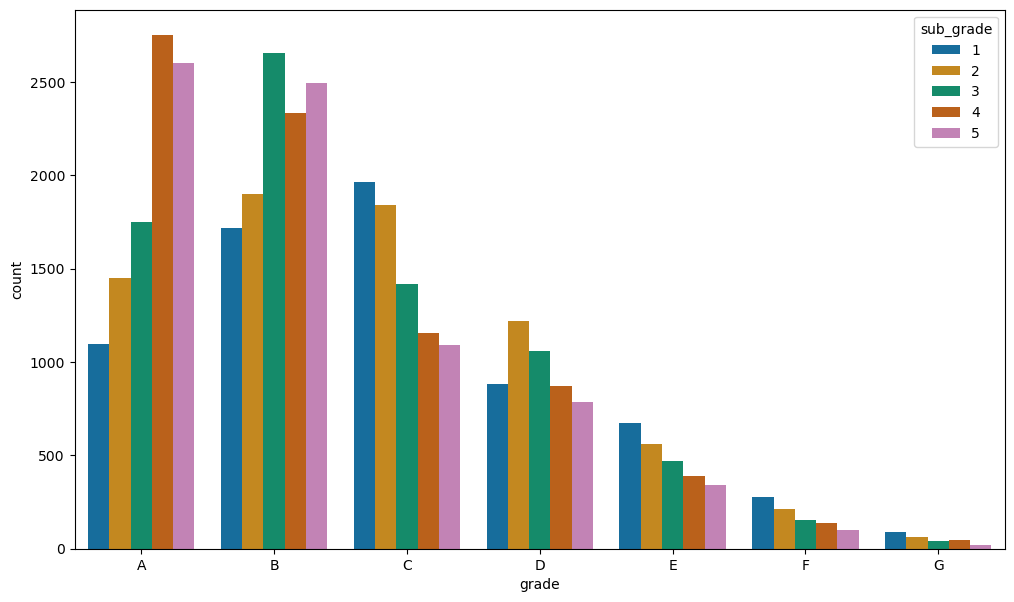

In [868]:
fig, ax = plt.subplots(figsize=(12,7))
sns.set_palette('colorblind')
sns.countplot(x = 'grade', order = ['A', 'B', 'C', 'D', 'E', 'F', 'G'] , hue = 'sub_grade',data = loan_data)


Clearly, as the grade of loan goes from A to G, the default rate increases. This is expected because the grade is decided by Lending Club based on the riskiness of the loan. 

##### home ownership: not a great discriminator

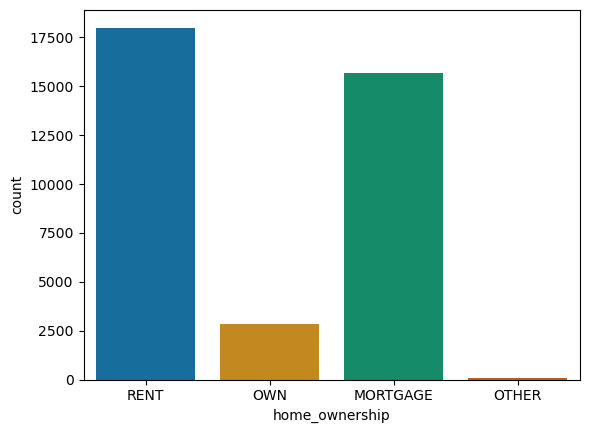

In [869]:
plot_categorically('home_ownership')

##### verification_status: surprisingly, verified loans default more than not verifiedb


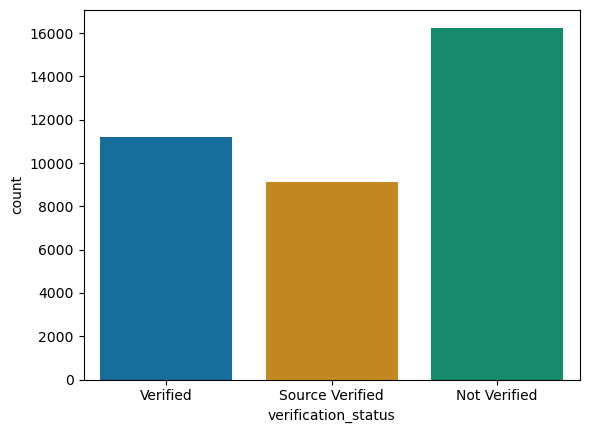

In [870]:
plot_categorically('verification_status')

##### purpose: small business loans defualt the most, then renewable energy and education


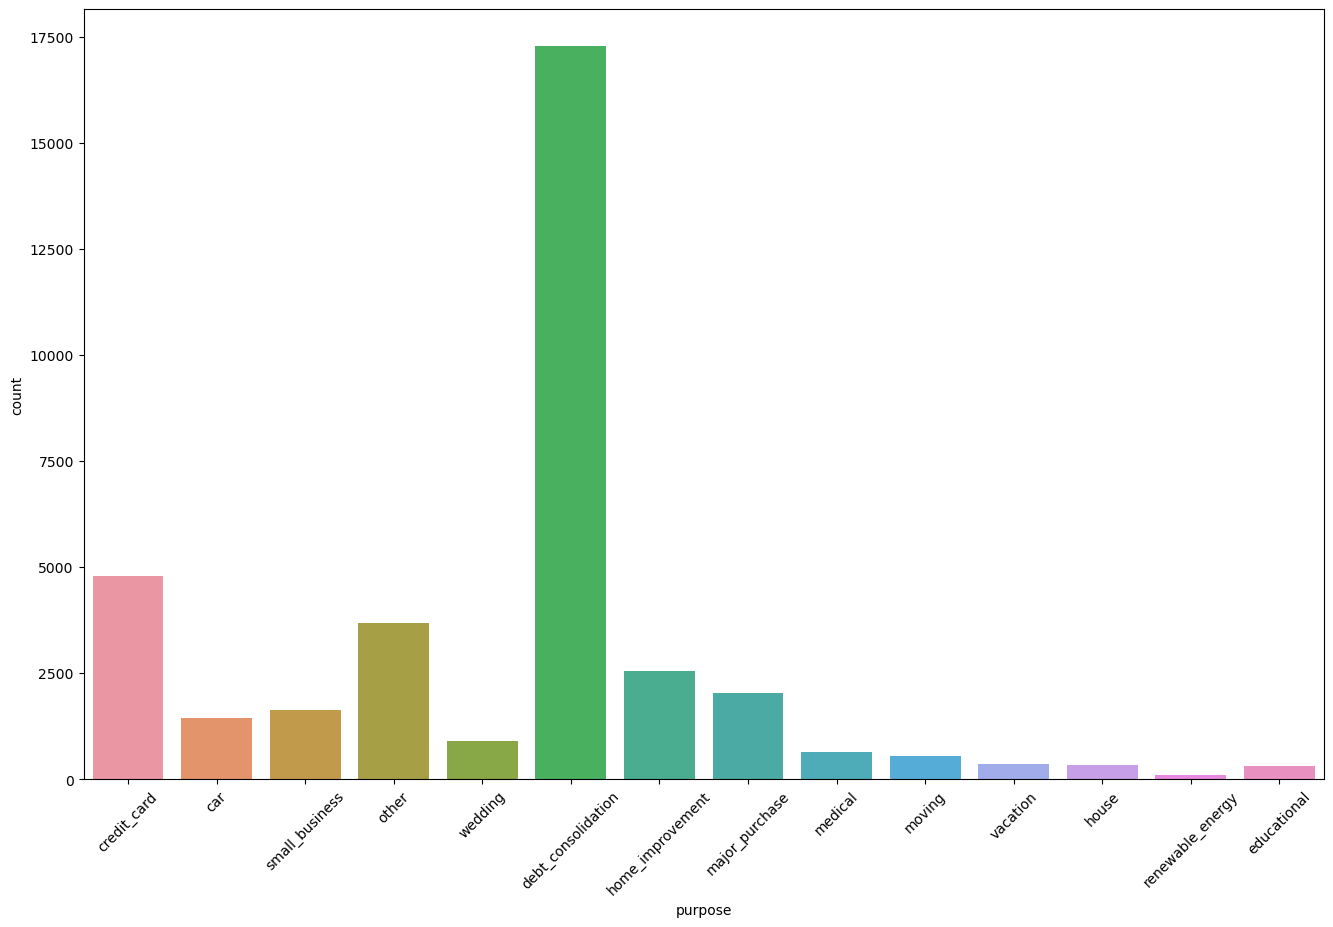

In [1000]:
plt.figure(figsize=(16, 10))
plot_categorically('purpose', True)

##### term: 60 months loans default more than 36 months loans

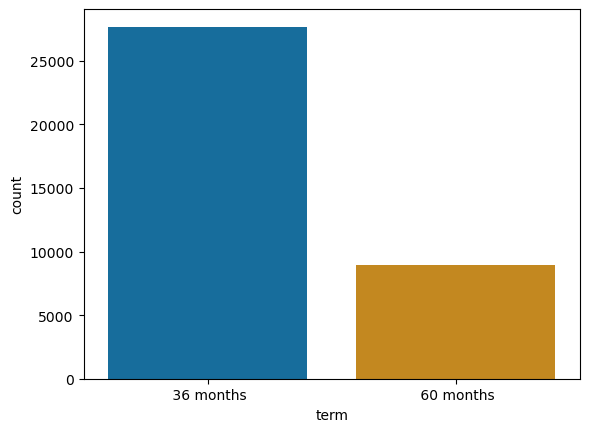

In [872]:
plot_categorically('term')

Let's now analyse how the default rate varies across continuous variables.

In [873]:
def transform_in_bins(variable_name, lablels_names, bins_size=5):
    loan_data[variable_name + '_groups'] = pd.cut(
        loan_data[variable_name], 
        bins=bins_size, precision =0, 
        labels=lablels_names
    )
    

##### Introducting a few groups variable for segment variable analysis

In [874]:
transform_in_bins('int_rate', ['5%-9%','9%-13%','13%-17%','17%-21%','21%-24%'])
transform_in_bins('revol_util', ['0-20','20-40','40-60','60-80','80-100'])
transform_in_bins('annual_inc', ['3k-31k','31k-58k','58k-85k','85k-112k','112k-140k'])
transform_in_bins('loan_amnt', ['0-5k','5k-10k','10k-15k','15k-20k','20k-25k','25k-30k','30k-35k'], 7)
transform_in_bins('funded_amnt_inv', ['0-5k','5k-10k','10k-15k','15k-20k','20k-25k','25k-30k','30k-35k'], 7)
transform_in_bins('installment', ['14-145','145-274','274-403','403-531','531-660','660-789','789-918','918-1047','1047-1176','1176-1305'], 10)

## 3.3 Univariate Analysis for continous variables

##### lets define a function to plot loan_status across categorical variables

In [875]:
def plot_continous_var(variable_name, plot_dem='x', group=True):
    fig, ax = plt.subplots(figsize = (15,10))
    ax.remove()
    plt.subplot(221)
    group_name=variable_name
    if group:
        group_name=variable_name +"_groups"
    
    if plot_dem == 'x':
        sns.countplot(x=group_name, data=loan_data[loan_data.loan_status == 1])
        plt.xlabel(variable_name)
    else:
        sns.countplot(y=group_name, data=loan_data[loan_data.loan_status == 1]) 
        plt.ylabel(variable_name)
    
    
    

##### Analysis interest rate segment variables against loan_status

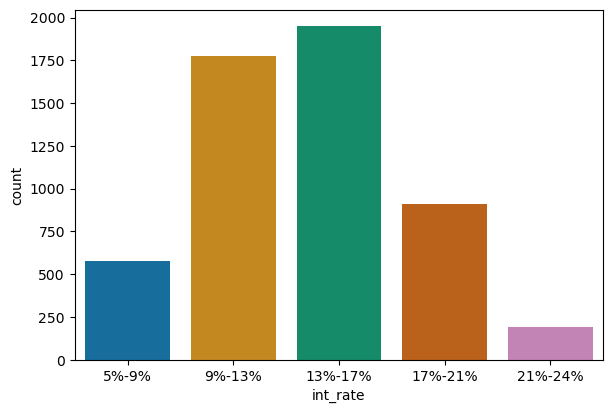

In [876]:
plot_continous_var('int_rate')

##### Analysis emp_length against loan_status

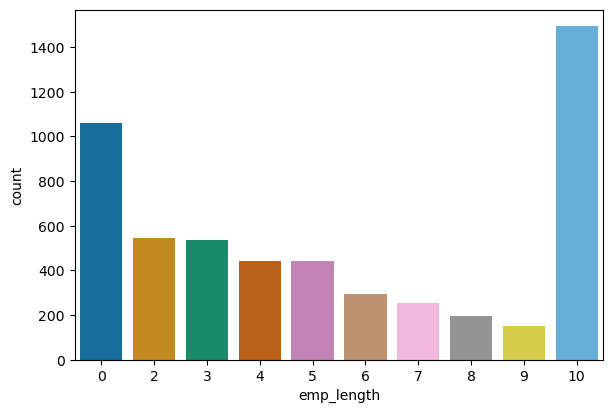

In [877]:
plot_continous_var('emp_length', 'x', False)

##### Analysis annual income against loan_status

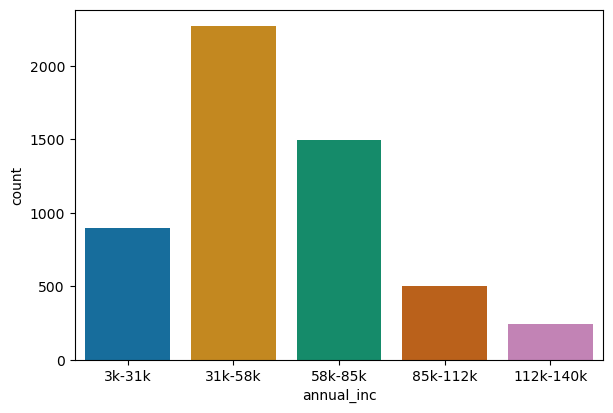

In [878]:
plot_continous_var('annual_inc')

##### Analysis revol_util against loan_status

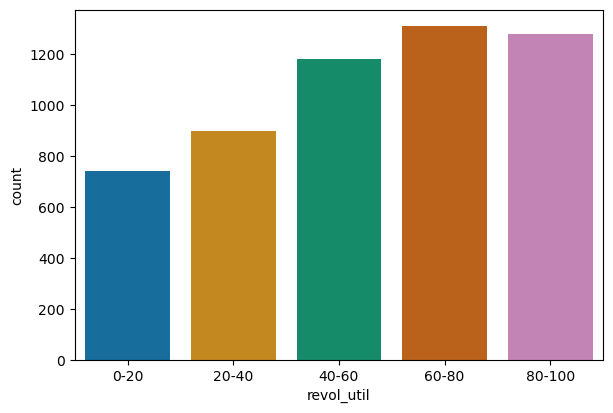

In [879]:
plot_continous_var('revol_util')

##### Analysis loan amount against loan_status

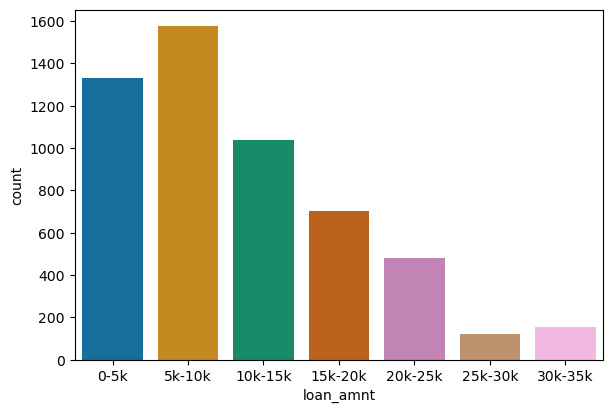

In [880]:
plot_continous_var('loan_amnt')

In [881]:
loan_data['funded_amnt_inv'].describe()

count    36606.000000
mean      9902.311039
std       6730.696329
min          0.000000
25%       4988.276705
50%       8396.342174
75%      13649.999283
max      35000.000000
Name: funded_amnt_inv, dtype: float64

##### Analysis funded_amnt_inv against loan_status

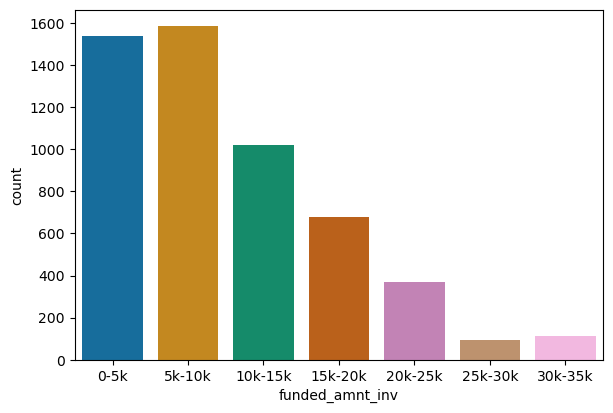

In [882]:
plot_continous_var('funded_amnt_inv')

##### Analysis installment against loan_status

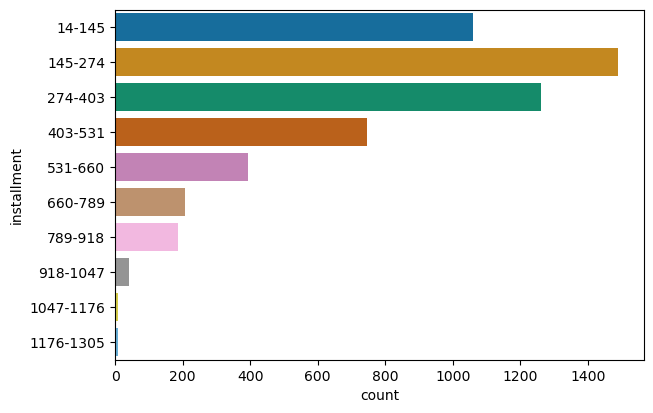

In [883]:
plot_continous_var('installment', 'Y')

## 3.4 Bivariate Data Analysis

Analyse continous variables with categorical variables and get more insights for our observations


### 3.4.1 Analyse loan amount with other categorical and distinct categories or intervals variables
- Categorical variables - grade, home_ownership, purpose
- Discrete or Binned variables - annual_inc_groups, int_rate_groups

In [884]:
def bivariate_barplot(x_variable, y_variable, tick_rotation=False):
    plt.figure(figsize=(20,10))
    ax = sns.barplot(data =loan_data, x=x_variable, y=y_variable, hue='loan_status', palette="pastel")
    handles, _ = ax.get_legend_handles_labels()
    if tick_rotation:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.legend(handles, ['Fully Paid', 'Charged Off'])
    plt.show()

#### Analyse Loan Amount b/w Grade


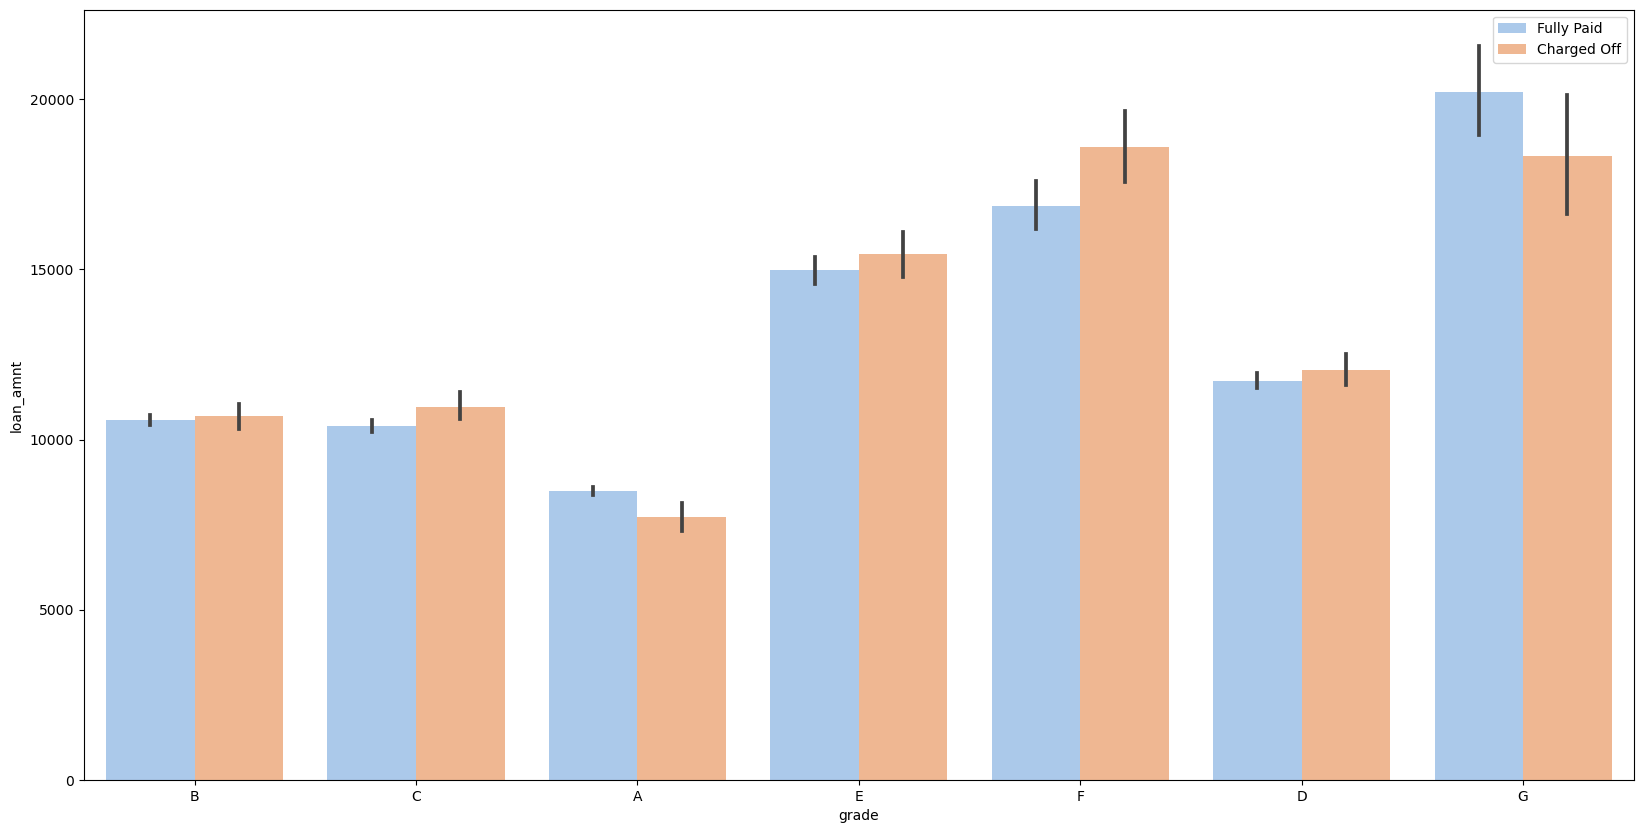

In [885]:
bivariate_barplot('grade', 'loan_amnt')

#### Analyse Loan Amount b/w Home Owner

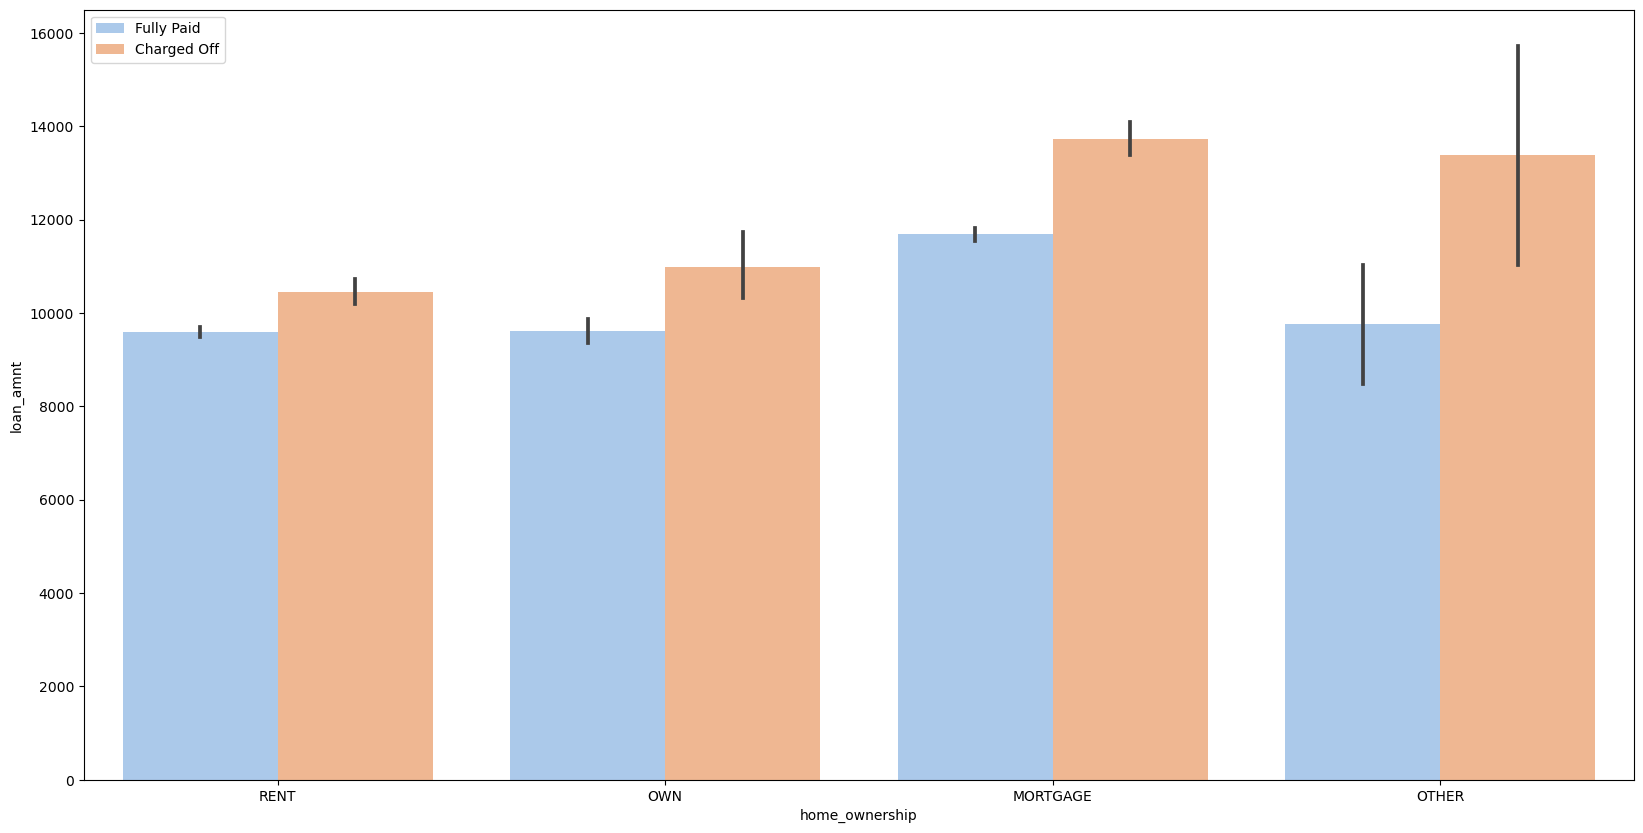

In [886]:
bivariate_barplot('home_ownership', 'loan_amnt')

#### Analyse Loan Amount b/w Purpose

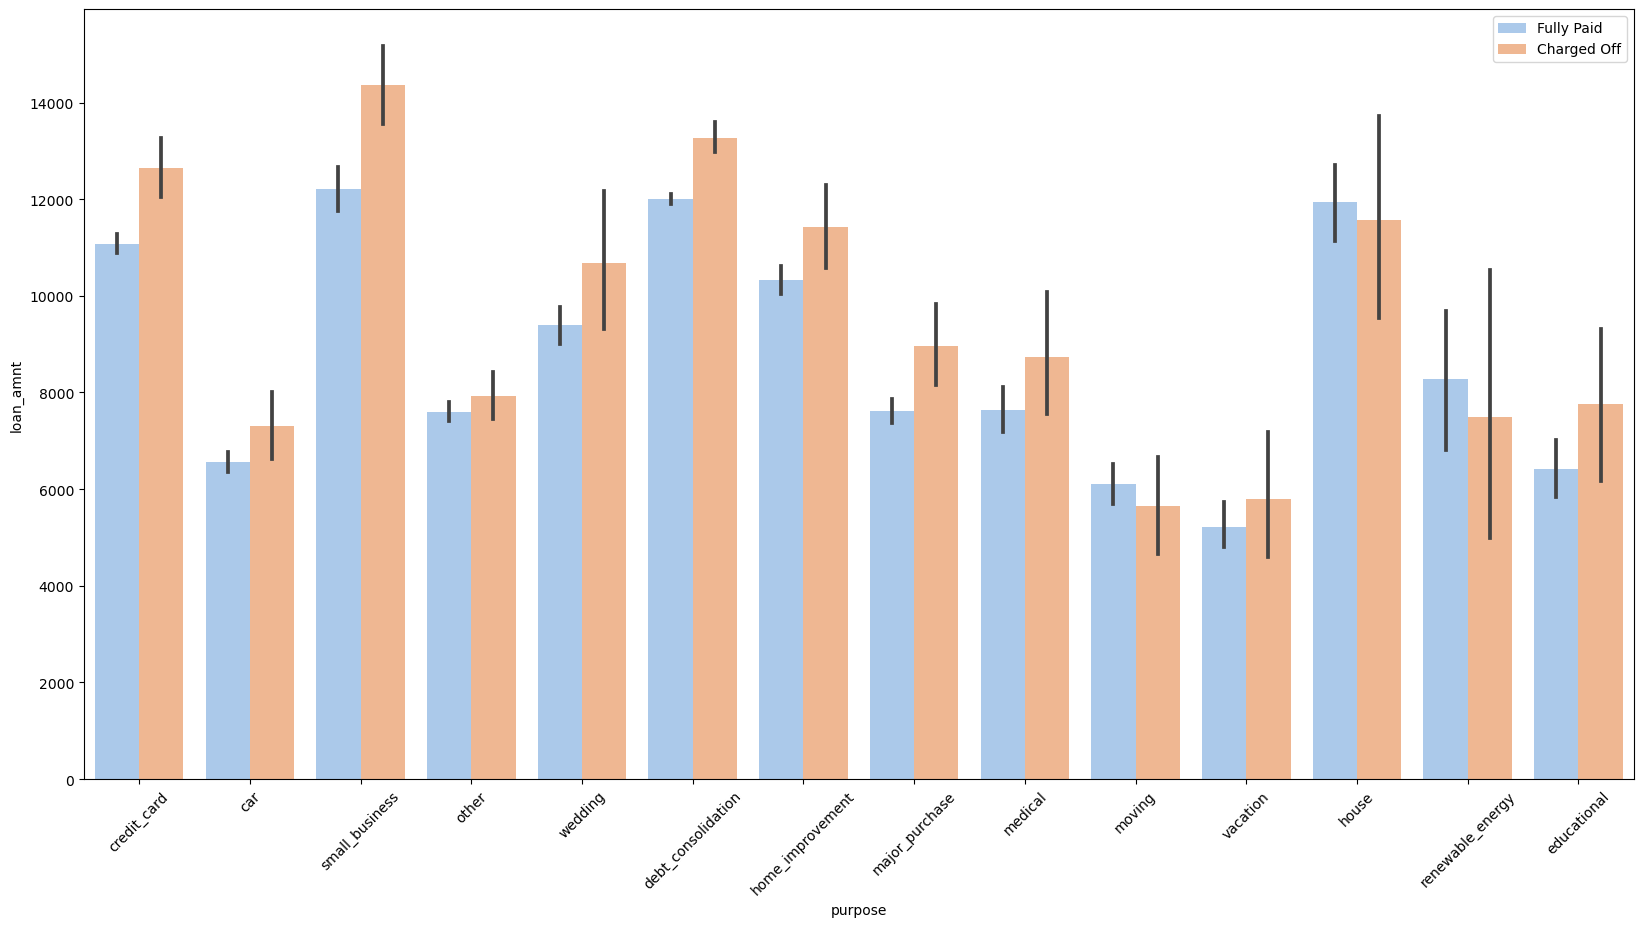

In [887]:
bivariate_barplot( 'purpose', 'loan_amnt', True)

#### Analyse Loan Amount b/w Annual income groups

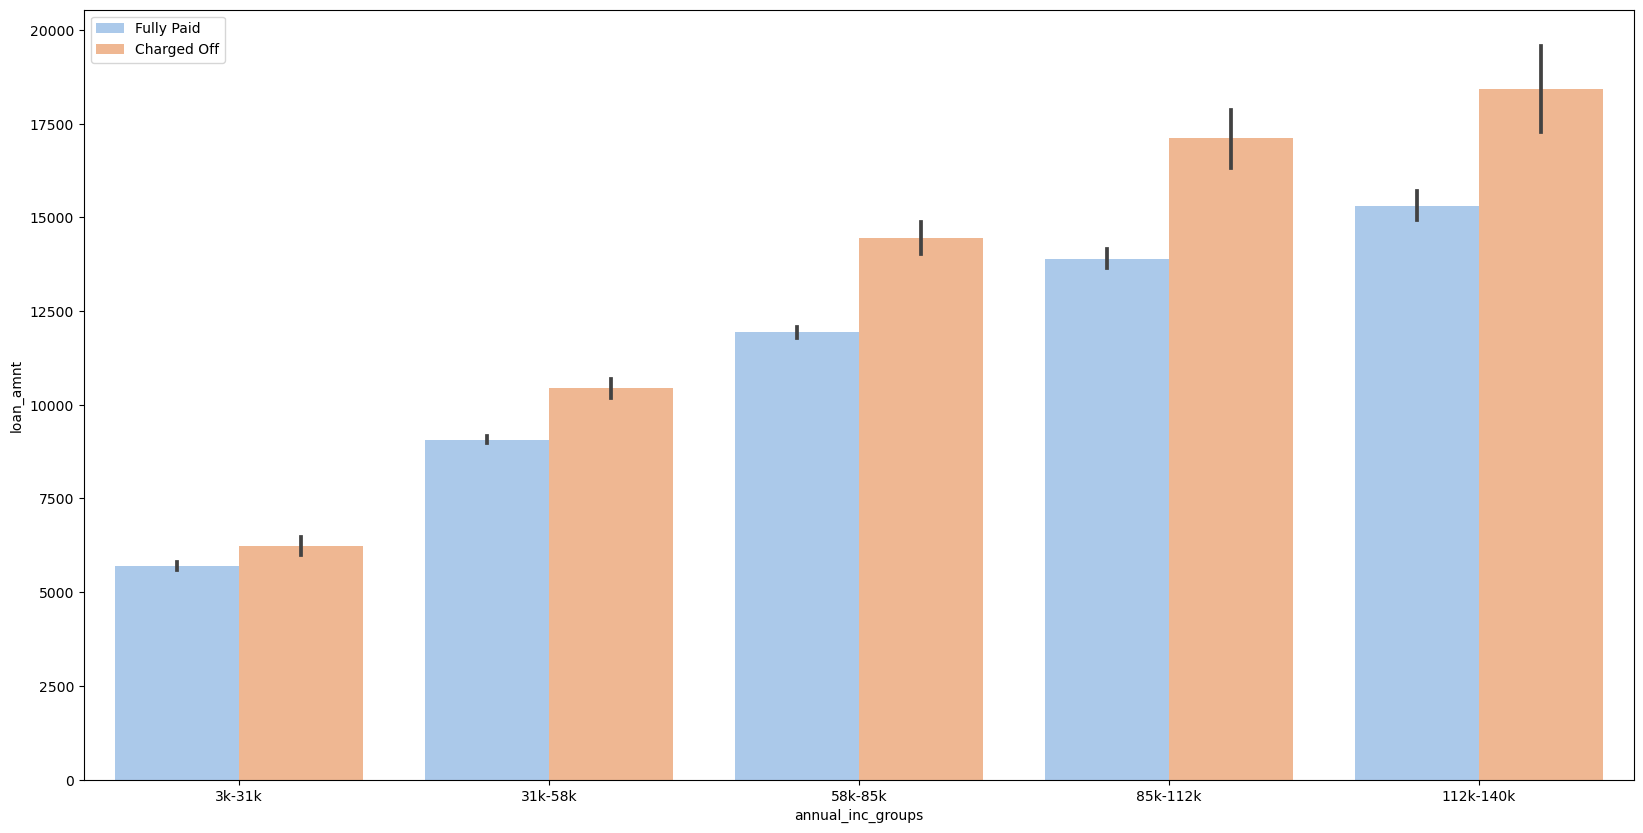

In [888]:
bivariate_barplot('annual_inc_groups', 'loan_amnt')

#### Analyse Loan Amount b/w Interest Rate Groups


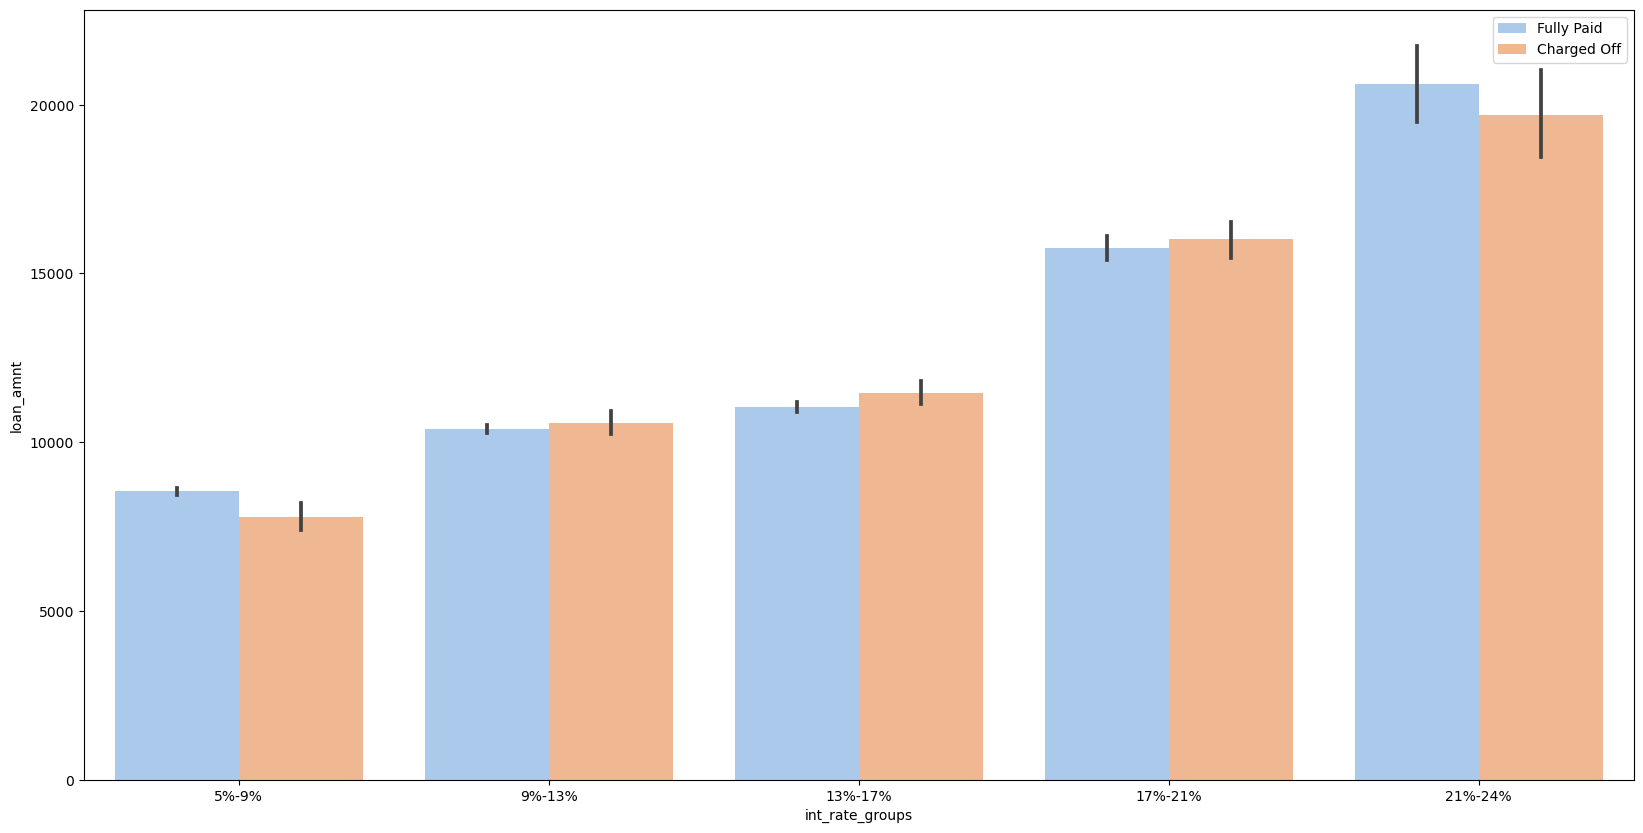

In [889]:
bivariate_barplot('int_rate_groups', 'loan_amnt')

### 3.4.2 Analyse Interest Rate with other categorical and distinct categories or intervals variables
- Categorical variables - purpose, grade
- Discrete or Binned variables - annual_inc_groups, funded_amnt_inv_groups, revol_util_groups

#### Analyse Interest Rate b/w Grade

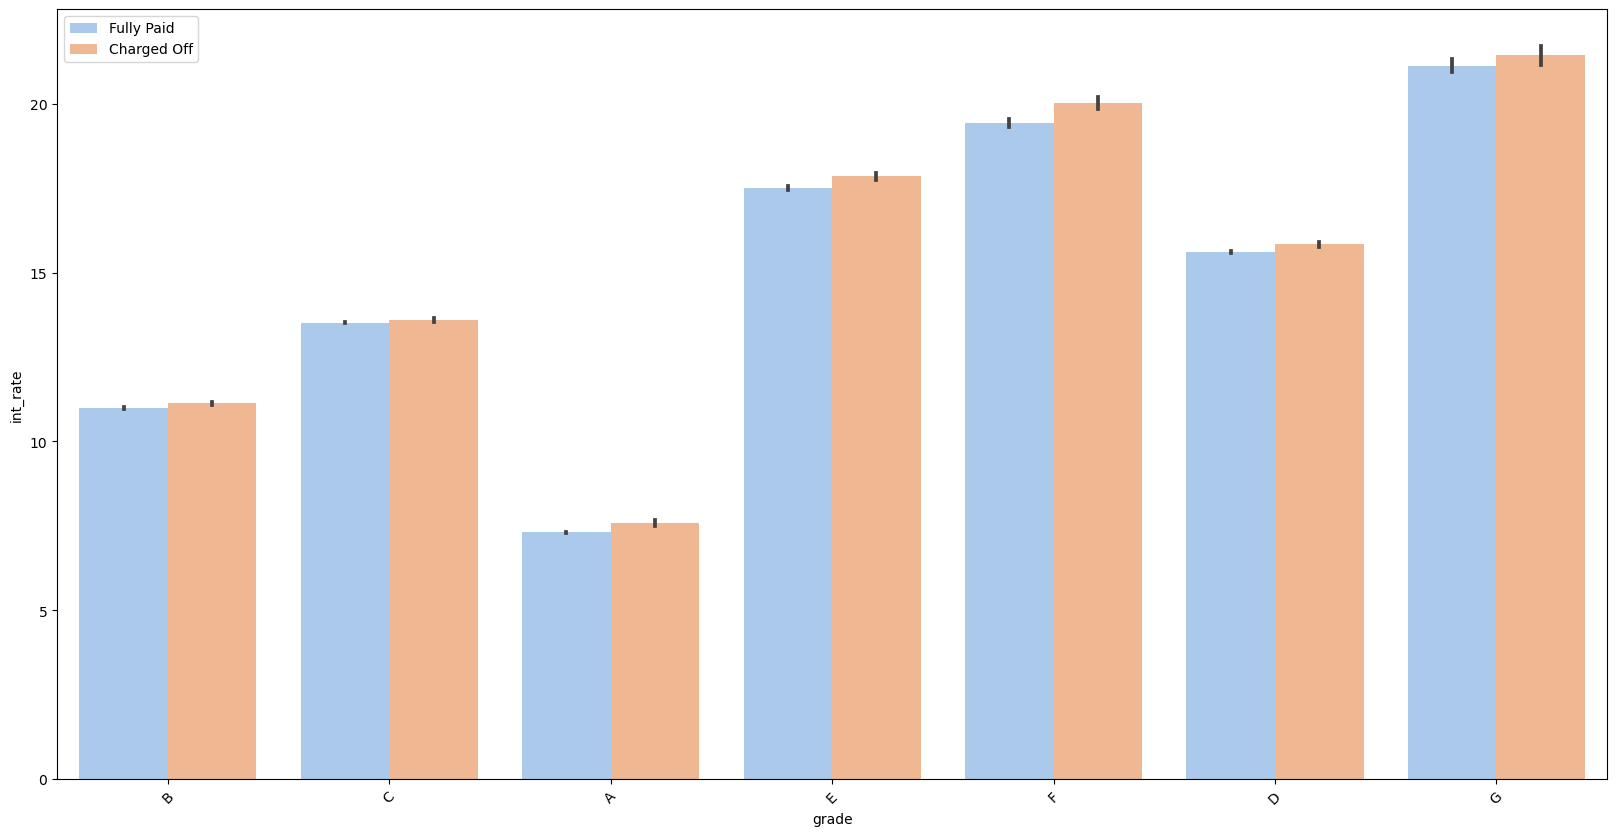

In [903]:
bivariate_barplot('grade', 'int_rate', True)

#### Analyse Interest Rate b/w Purpose

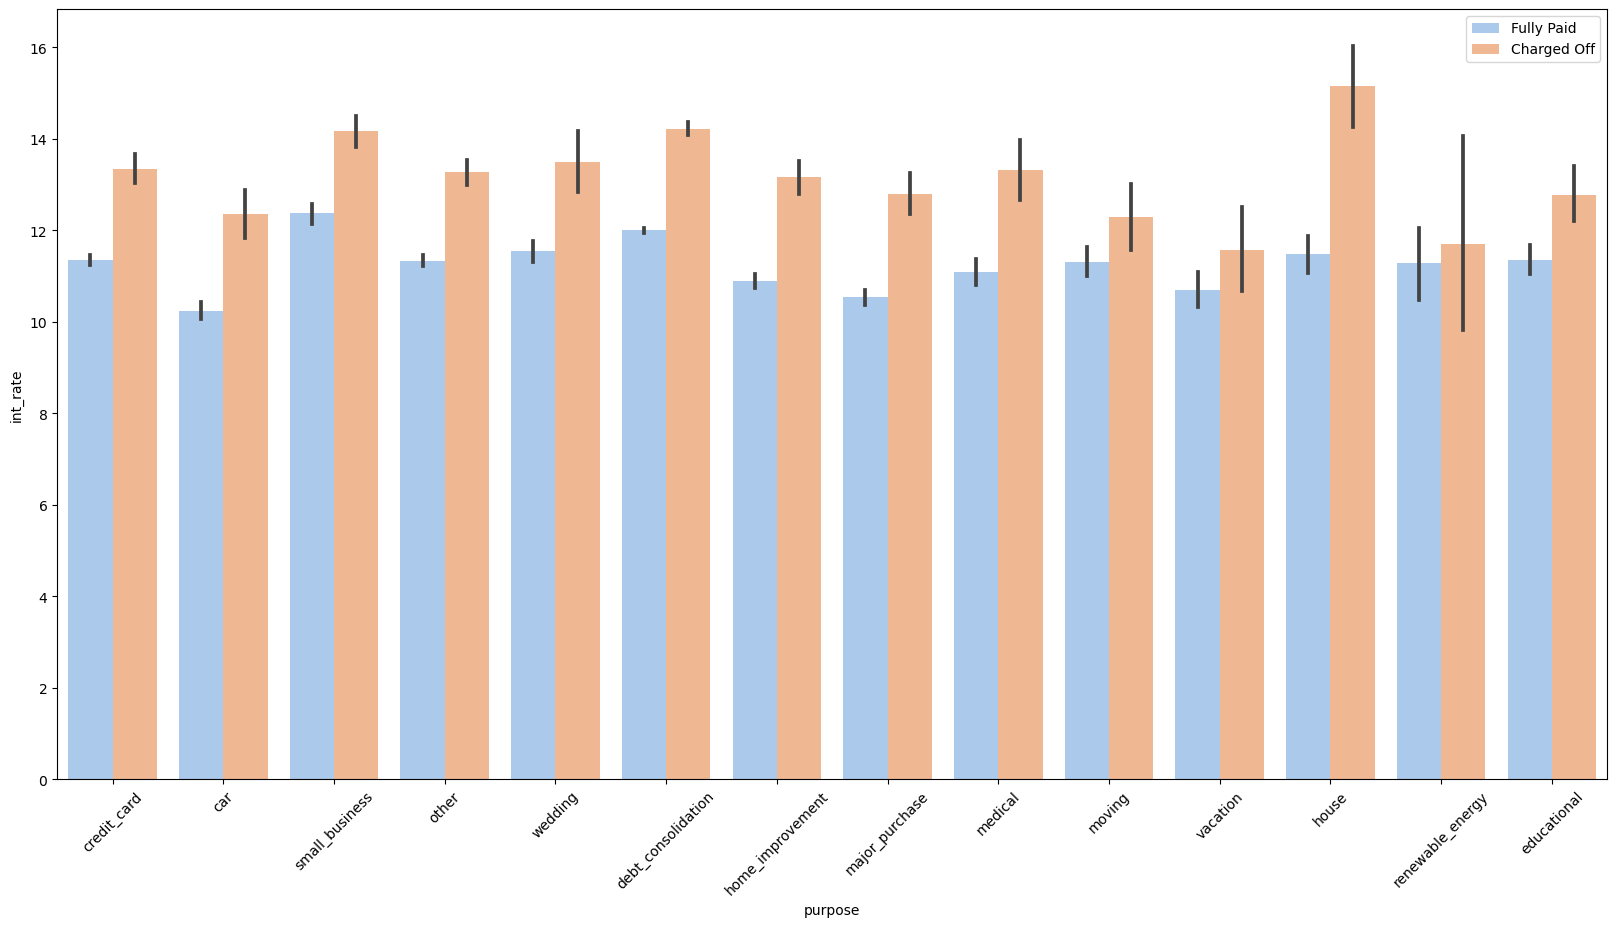

In [890]:
bivariate_barplot('purpose', 'int_rate', True)

#### Analyse Interest Rate b/w Annual income

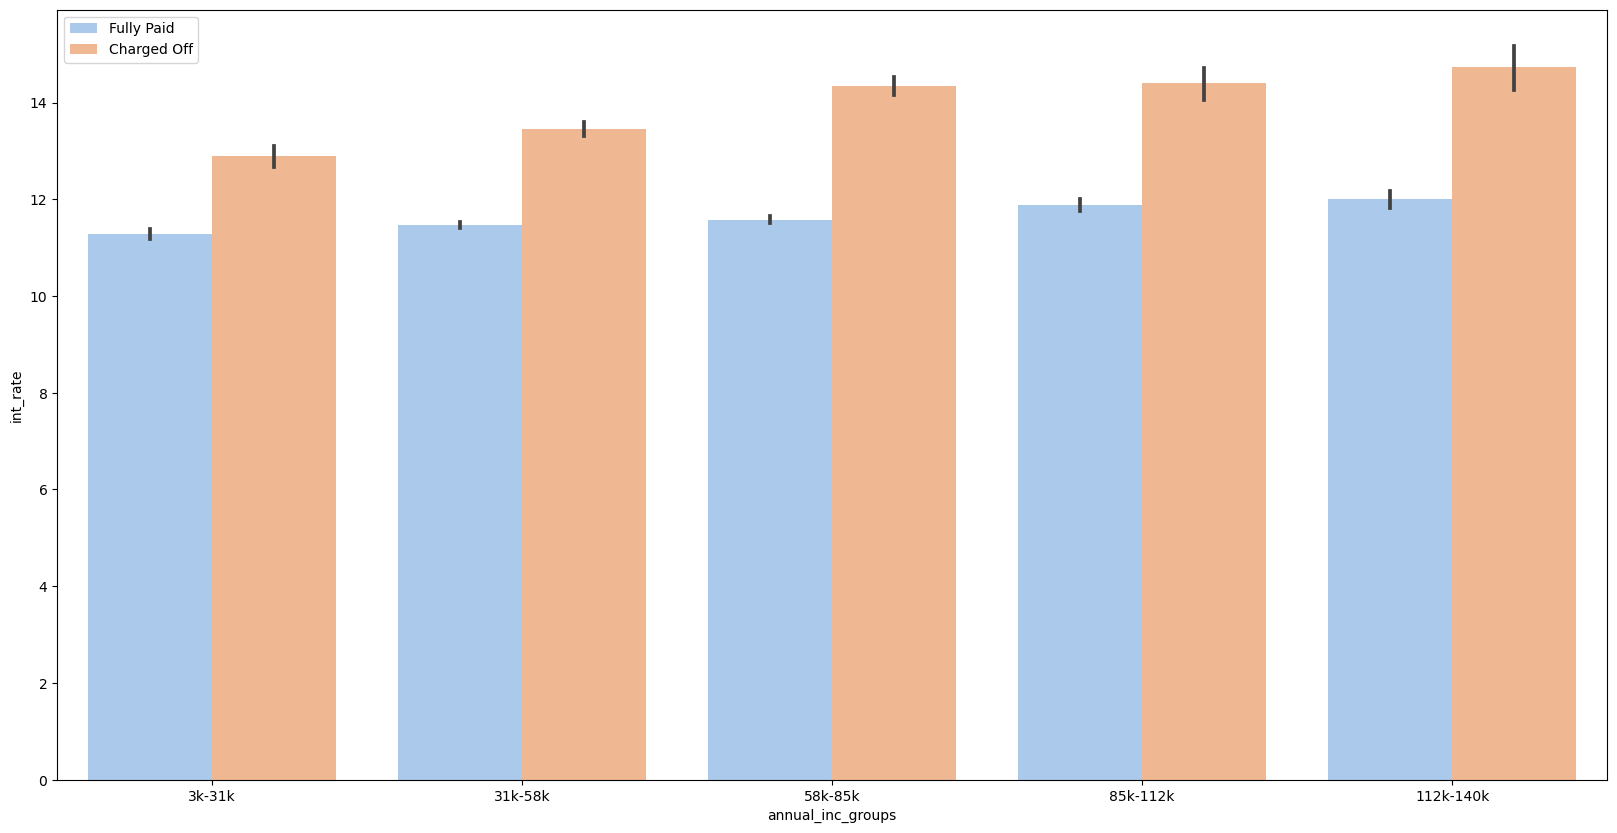

In [891]:
bivariate_barplot('annual_inc_groups', 'int_rate')

#### Analyse Interest Rate b/w Funded Amount by Invester Groups

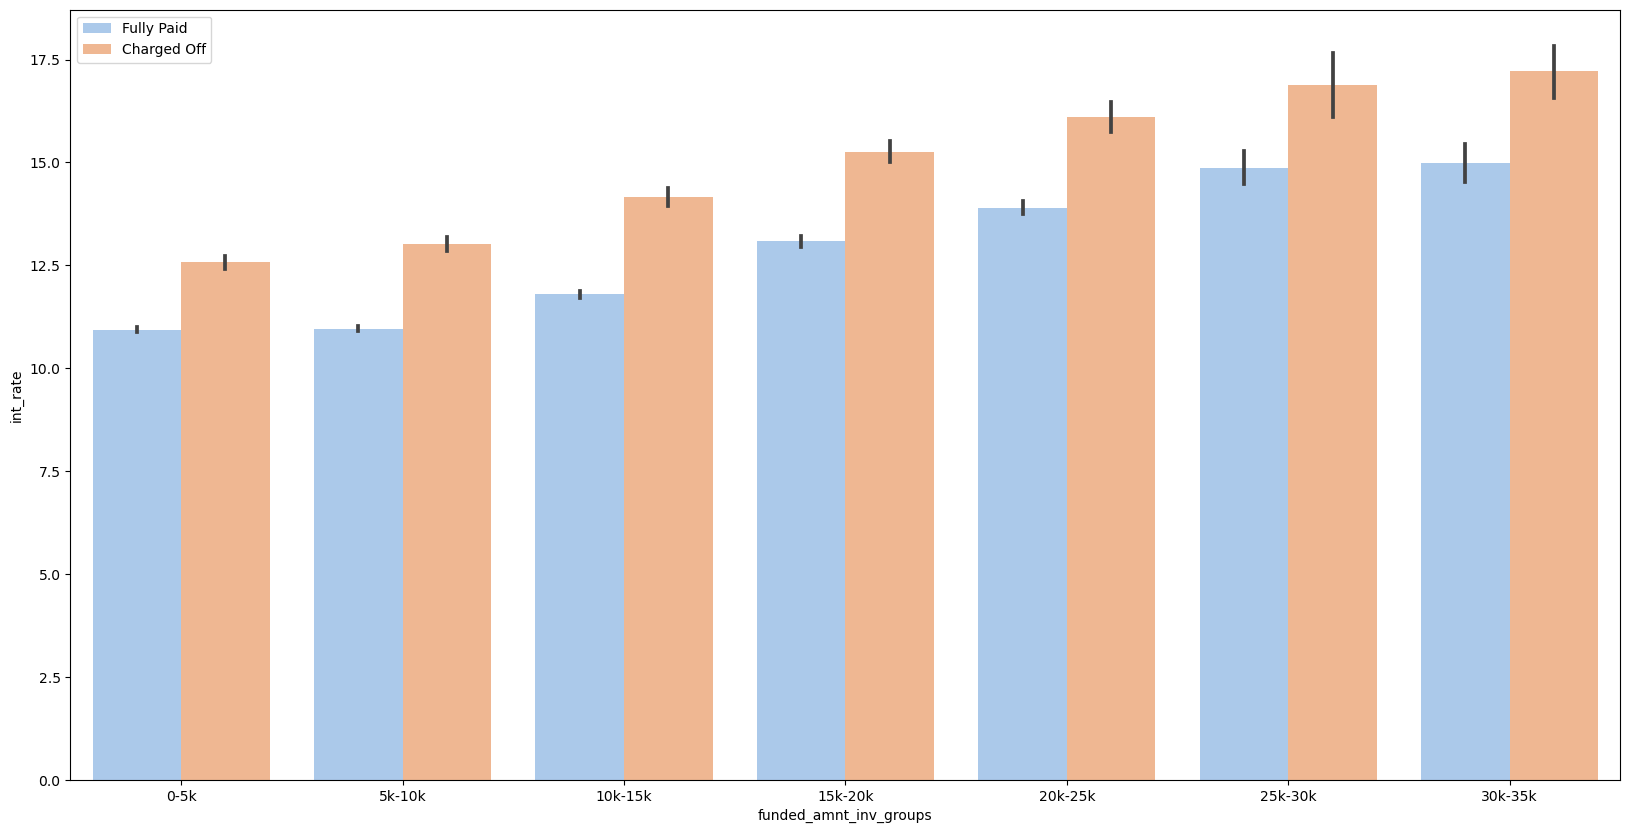

In [892]:
bivariate_barplot('funded_amnt_inv_groups', 'int_rate')

### 3.4.3 Analyse Installment with other categorical and distinct categories or intervals variables
- Categorical variables - home_ownership, purpose
- Discrete or Binned variables - annual_inc_groups

#### Analyse Installment b/w Home Ownership

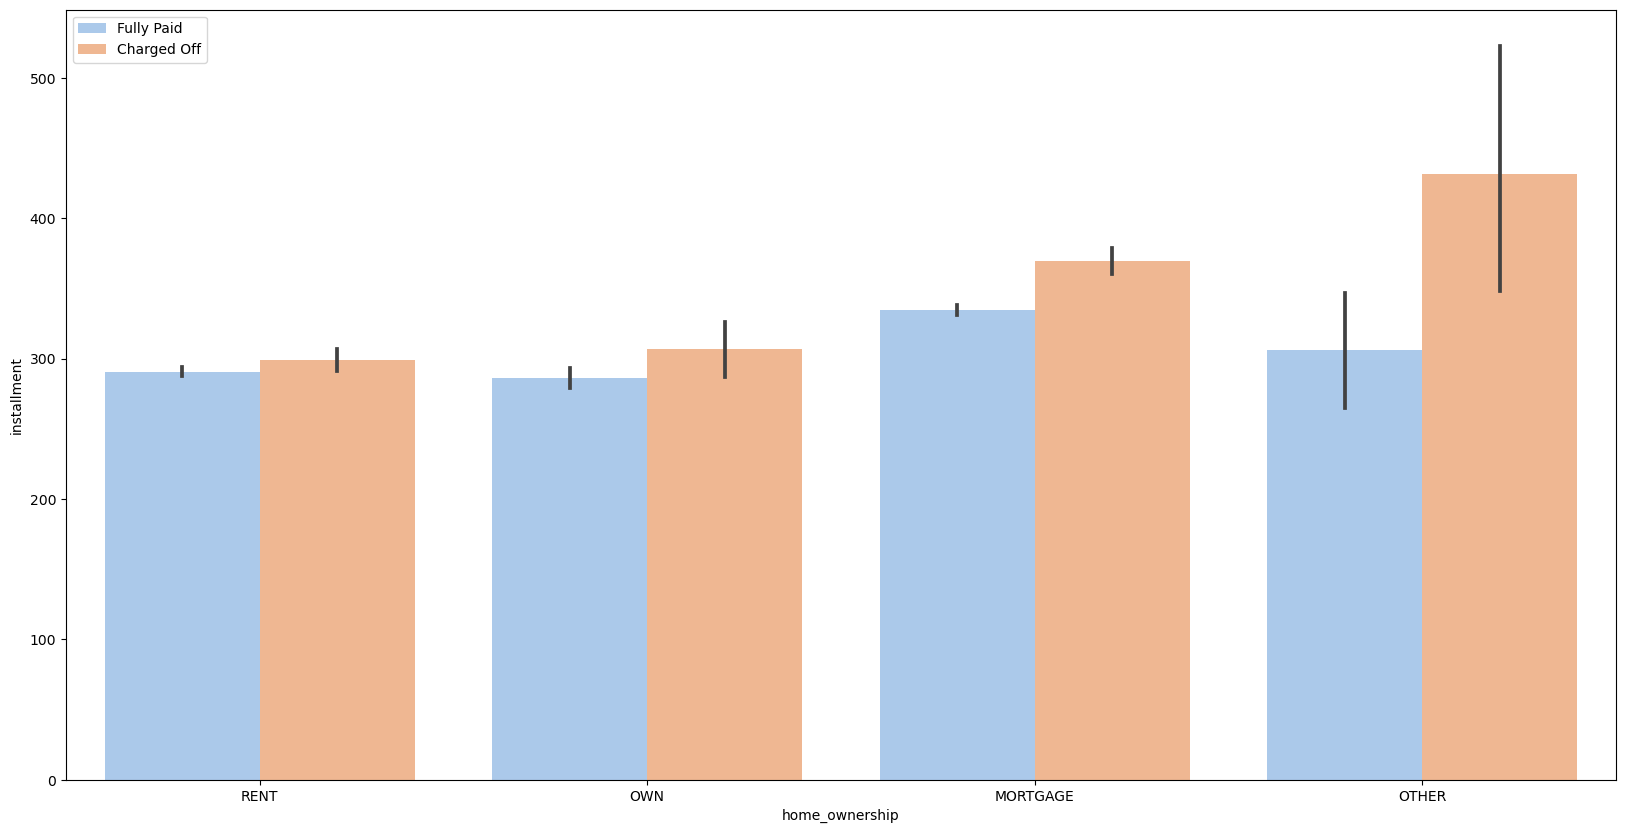

In [893]:
bivariate_barplot('home_ownership', 'installment')

#### Analyse Installment b/w Loan Purpose

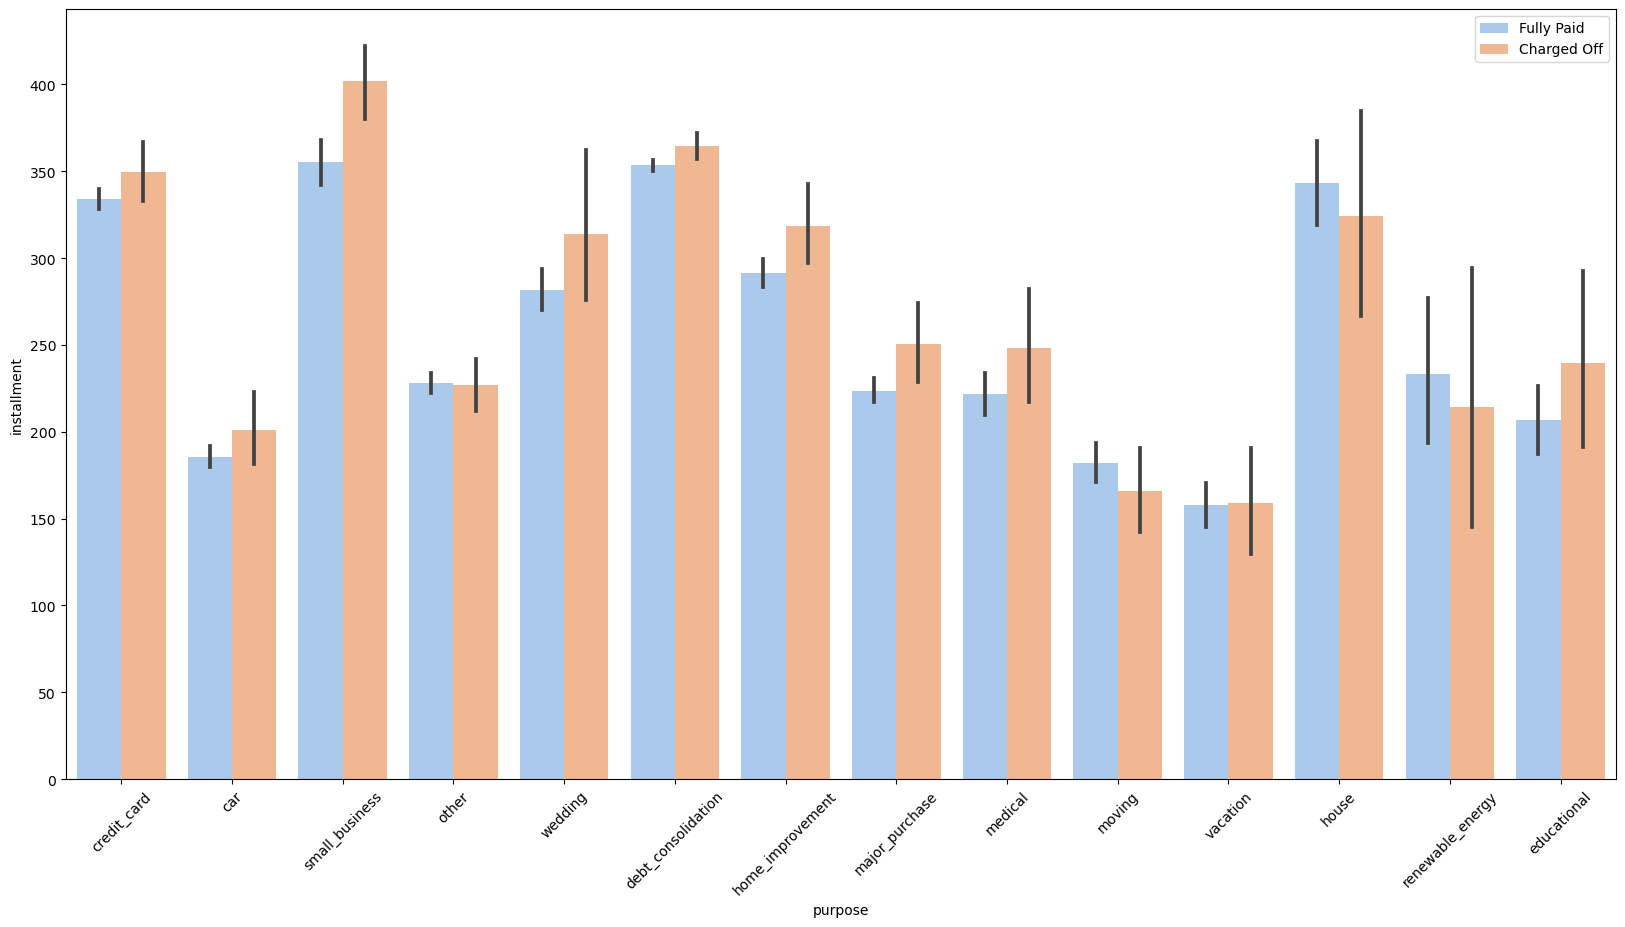

In [894]:
bivariate_barplot('purpose', 'installment', True)

#### Analyse Installment b/w Annual Income Groups

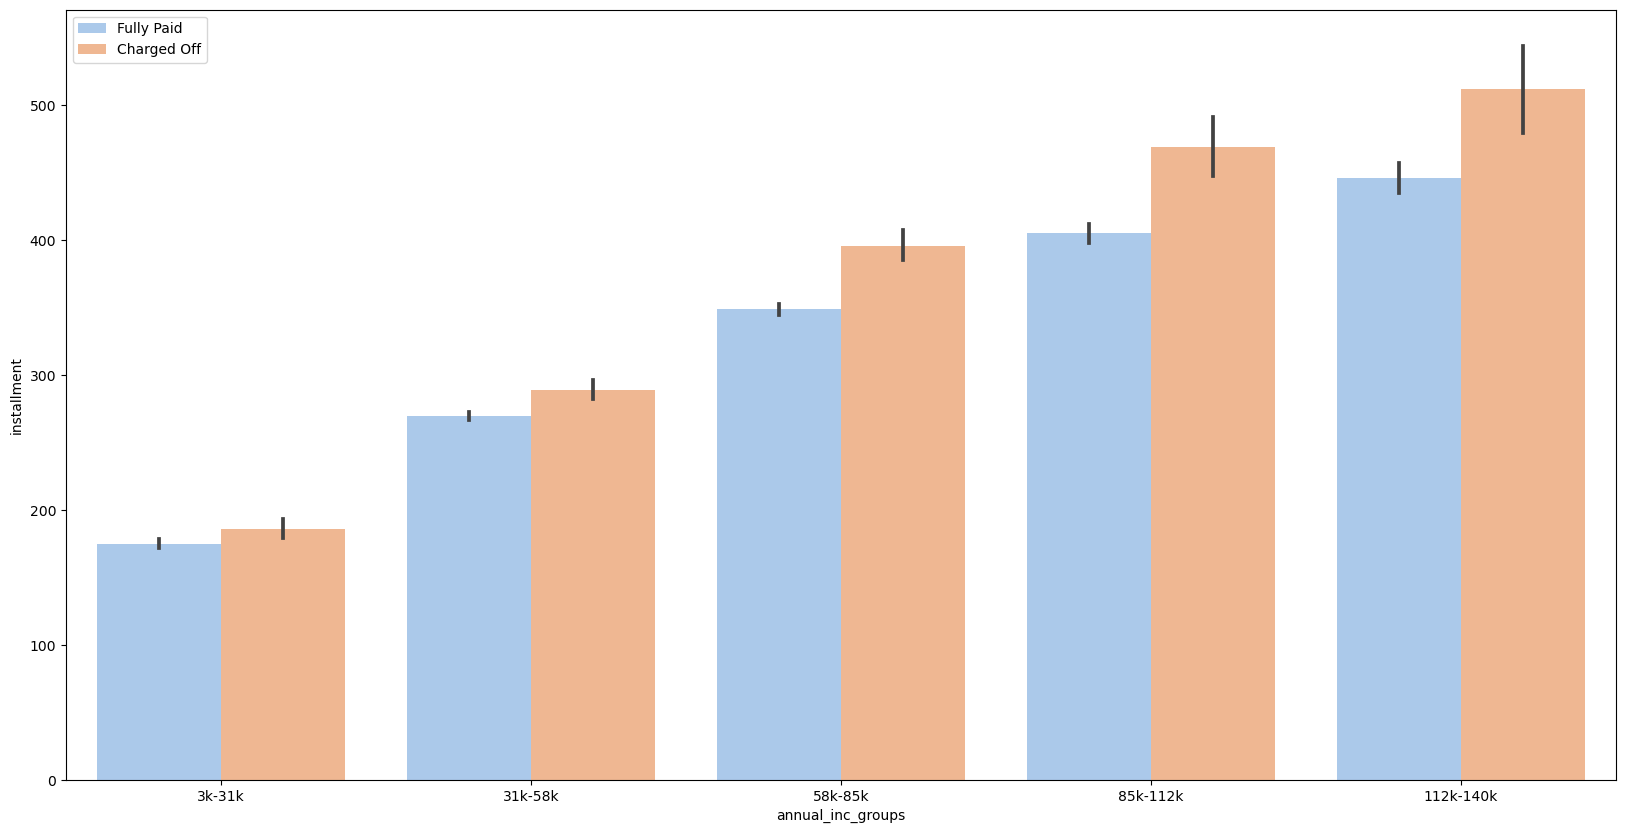

In [895]:
bivariate_barplot('annual_inc_groups', 'installment')

### 3.4.3 Analyse Employment Length with other categorical and distinct categories or intervals variables
- Categorical variables - home_ownership, purpose
- Discrete or Binned variables - annual_inc_groups

#### Analyse Employment Length b/w home_ownership

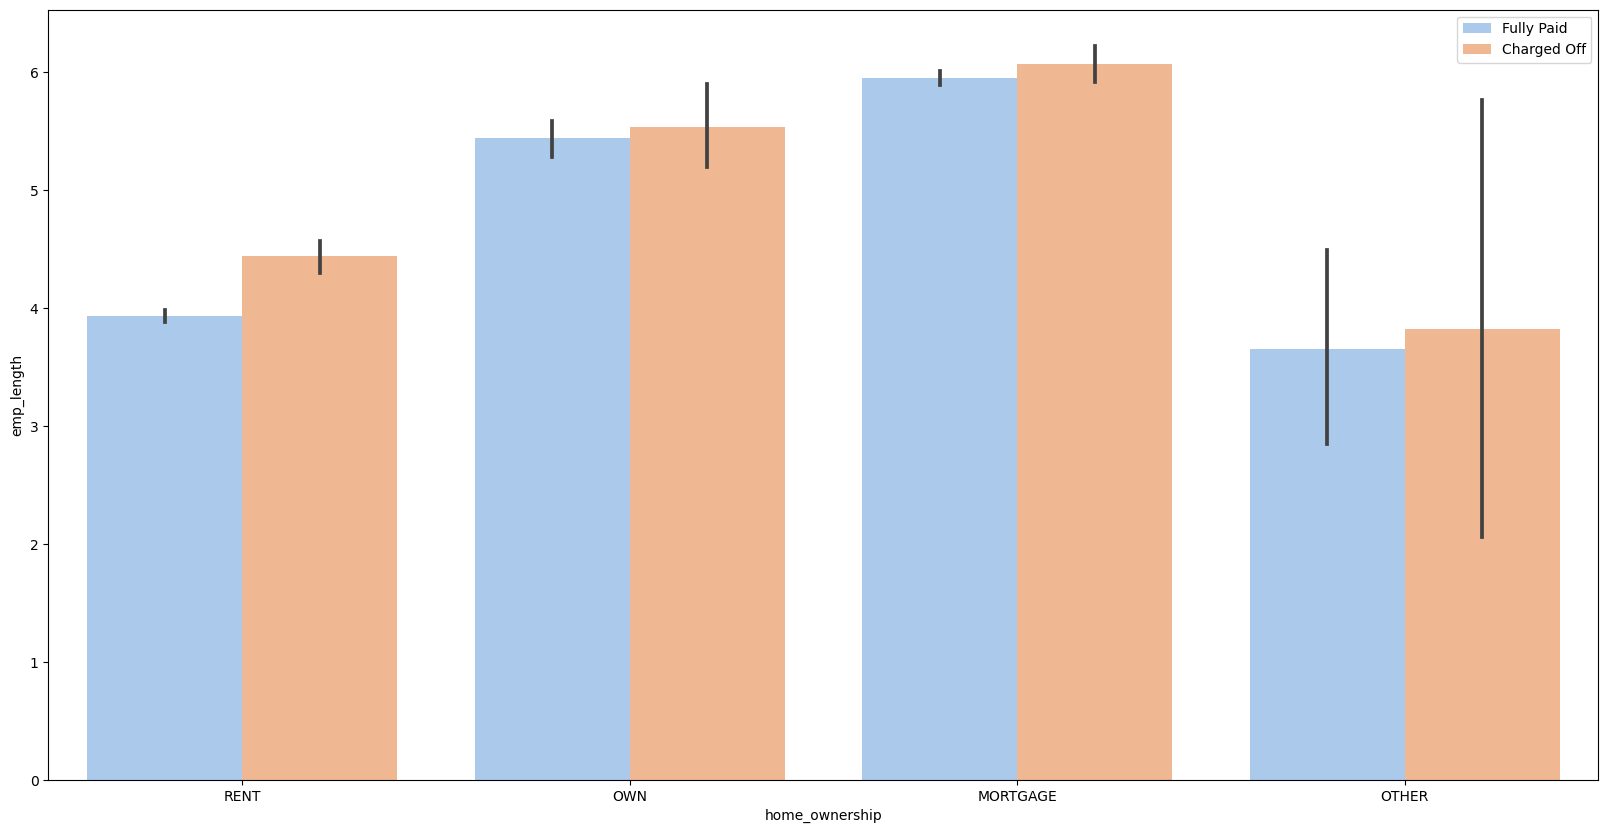

In [896]:
bivariate_barplot('home_ownership', 'emp_length')

#### Analyse Employment Length b/w Loan Purpose

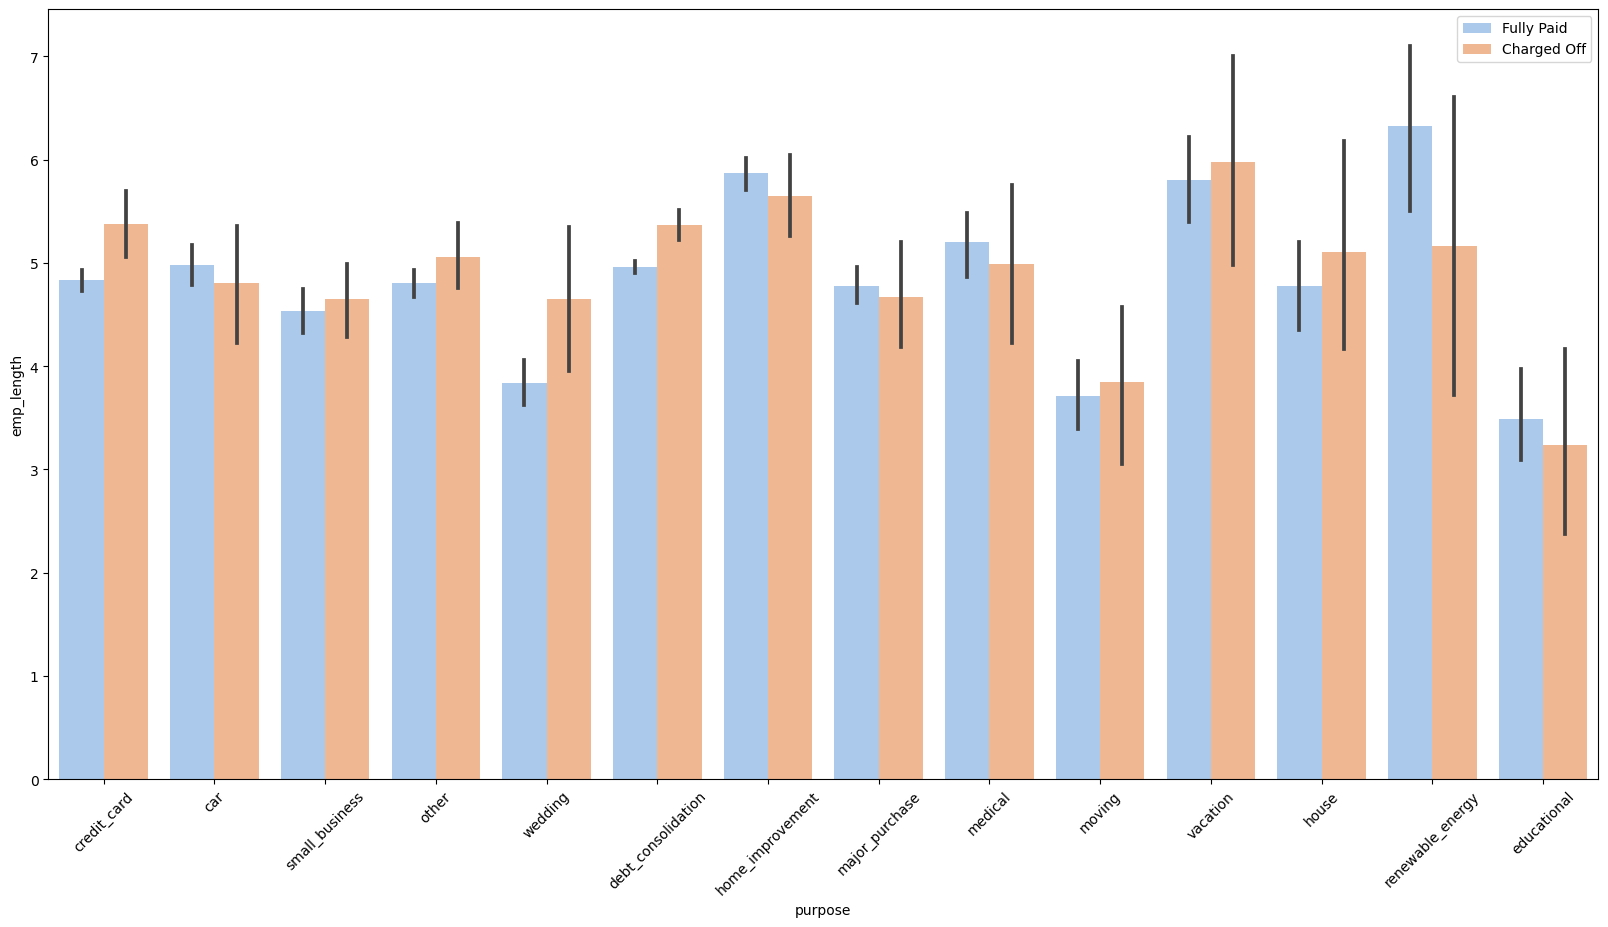

In [897]:
bivariate_barplot('purpose', 'emp_length', True)

#### Analyse Employment Length b/w Annual Income Group

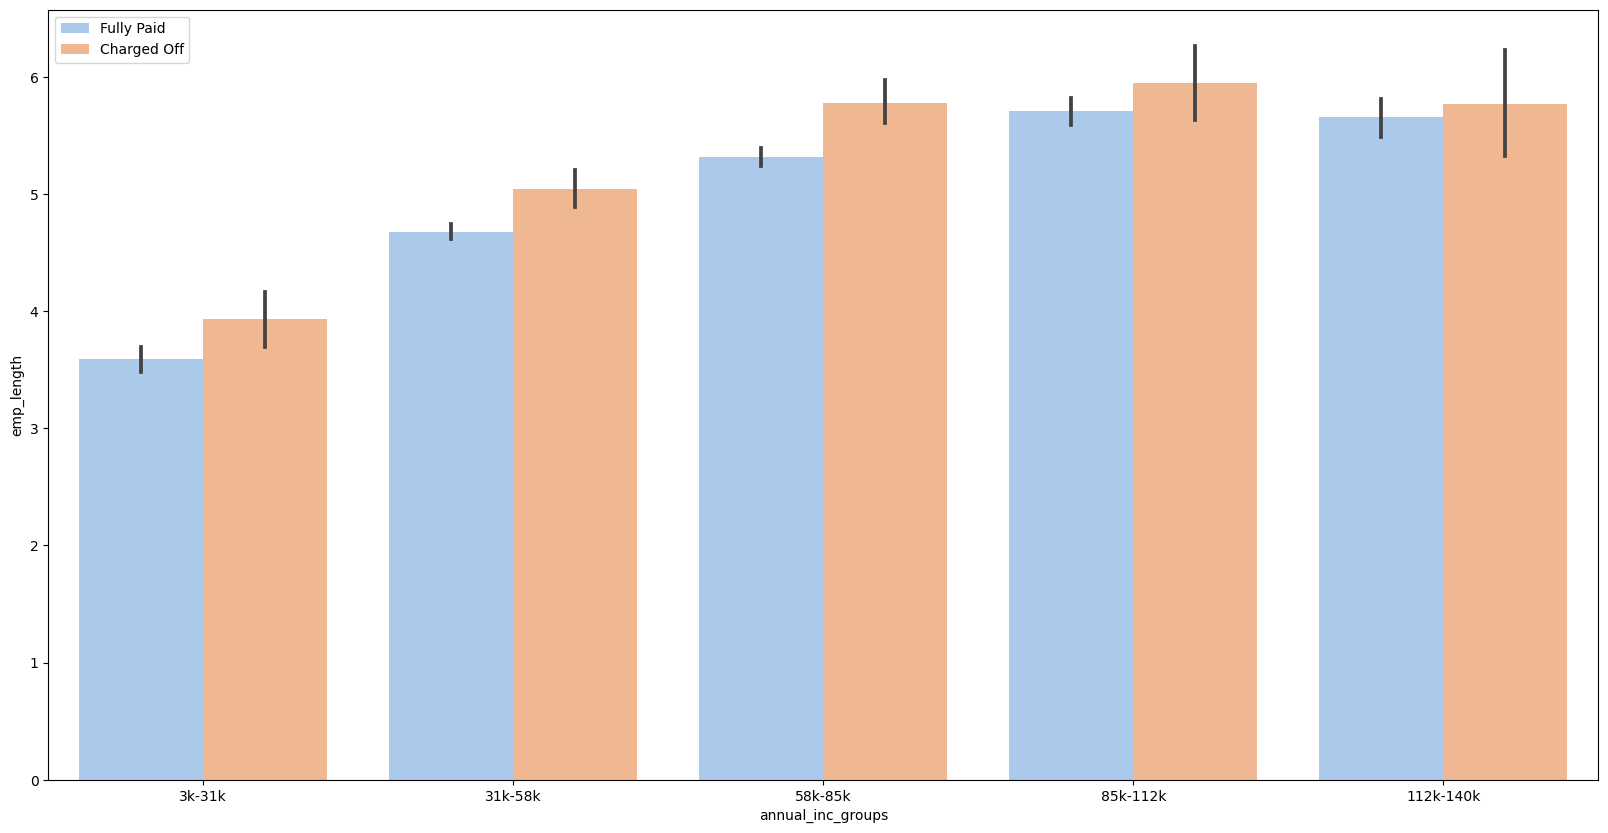

In [898]:
bivariate_barplot('annual_inc_groups', 'emp_length')

# Observations 

## The following factors are associated with a higher probability of defaulting on charged off loans:

### Univariate Analysis Observations:

- **Loan Grade**: Loans with a grade of 'G' have a higher likelihood of defaulting.
- **Sub Grade Level**: Loans with a total grade of 'F5' have a higher probability of defaulting.
- **House Ownership**: Applicants who have house_ownership listed as 'RENT' are more likely to default on loans compared to other types of house ownership.
- **Verification**: Loans that are not verified have a higher probability of defaulting.
- **Loan Purpose**: Applicants who use the loan to clear other debts, specifically for debt consolidation, have a higher probability of defaulting.
- **Loan Term**: Loans with a term of 36 months are more likely to default compared to longer-term loans.
- **Interest Rate**: Applicants who receive loans with an interest rate in the range of 13-17% are more likely to default.
- **Employment Length**: Applicants who has more than 10 years of working status are likely to default.
- **Income Range**: Applicants with an income between the range of 31,201-58,402 have a higher probability of defaulting on loans.
- **Loan Amount**: Loans with amounts between 5,429-10,357 have a higher likelihood of defaulting.
- **Funded Amount**: Loans with a funded amount by investors between 5,000-10,000 are associated with a higher probability of defaulting.
- **Monthly Installments**: Loans with monthly installments between 145-274 are associated with a higher likelihood of defaulting.

### Bivariate Analysis Observations:
- **Loan Grade and Loan Amount**: Loans with a grade of 'F' and a loan amount between 15,000-20,000 are more likely to default.
- **Home Ownership and Loan Amount** : Applicants with 'MORTGAGE' as their home ownership status and a loan amount in the range of 14,000-16,000 have a higher probability of defaulting.

- **Home Ownership and Income** : Applicants with 'MORTGAGE' as their home ownership status and an income of 60,000-70,000 have a higher probability of defaulting.

- **Loan Purpose and Loan Amount** : Applicants who have taken a loan for a small business and the loan amount is greater than 14,000 are associated with a higher likelihood of defaulting.

- **Loan Purpose and Income**: Applicants who take a loan for 'home improvement' and have an income in the range of 60,000-70,000 are more likely to default.

- **Income Group and Loan Amount**:

- **Interest Rate and Income** : Applicants who receive loans with an interest rate in the range of 21-24% and have an income of 70,000-80,000 are more likely to default.
- **Loan Amount and Interest Rate** : Applicants who have taken a loan in the range of 30,000-35,000 and are charged an interest rate of 15-17.5% have a higher probability of defaulting.

- **Loan Grade and Interest Rate** : Loans with a grade of 'G' and an interest rate above 20% are associated with a higher probability of defaulting.
- **Loan Purpose and Interest**: Applicants who has taken loan for house are likely to be defaulting the loan.

- **Income Group and Interest**: Applicants who has taken loan for house and interest above 14% are likely to be defaulting the loan.

- **Funded Amount and Interest**: Applicants who have taken a loan in the range of 30,000-35,000 and are charged an interest rate of 15-17.5% have a higher probability of defaulting.

- **Home Ownership and Installment**: Applicants with 'Other' as their home ownership status and monthly installment above 400 are a higher probability of defaulting.


- **Loan Purpose and Installment**: Applicants who has taken the loan for small business and monthly installment above 400 are a higher probability of defaulting.

- **Income Group and Installment**: Applicants are in the amount group 112k-140k and monthly installment above 500 are high change to be default.

- **Employment Length and Loan Purpose** : Applicants with an employment length of more 5 years and a loan purpose are credit card or vacation are a higher probability of defaulting.

- **Employment Length and Loan Amount** : Applicants with an employment length of 10 years and a loan amount in the range of 12,000-14,000 have a higher probability of defaulting.
